__File: operator_evolution_fig.ipynb__

__Author:   A. J. Tropiano (tropiano.4@osu.edu)__<br/>
__Date:     Jan 07, 2020__

This notebook creates figures for _Operator evolution from the similarity renormalization group and the Magnus expansion_. Each function creates or returns values for a calculation. Use the cells below functions to run functions and save figures to the __Figures/Operator_evolution__ folder.

__Revision history:<br/>__
* Jan 07, 2020 - Created by combining several Jupyter notebooks: srg_potentials_fig.ipynb, srg_observables_fig.ipynb, srg_operators_fig.ipynb, and magnus_fig.ipynb. Note, some of these notebooks could be in Old_codes.
* Jan 22, 2020 - Added universality_test function.
* Feb 05, 2020 - Added functions that look at the SRG unitary transformations directly.
* Feb 26, 2020 - Updating functionality of the notebook. Functions will now return f, ax. Add extra labels outside the functions in cells below.

In [1]:
from os import chdir, getcwd
import matplotlib.colors as colors
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
%matplotlib inline
from numpy import linalg as la
import numpy as np
from scipy.linalg import expm
# Scripts made by A.T.
from Figures import figures_functions as ff
from Figures import register_colormap
import observables as ob
import operators as op
from Potentials.vsrg_macos import load_save_potentials as lsp
from Potentials.vsrg_macos import sdt_funcs as sdt
from SRG_codes.srg_unitary_transformation import SRG_unitary_transformation

__Variables and constants__

In [2]:
# Current working directory
cwd = getcwd()

# kvnns
# EMN N4LO 500 MeV, RKE N4LO 450 MeV, Gezerlis N2LO 1 fm
kvnns_default = (79, 111, 222)
# Non-local LO \Lambda = 4, 9, 20 fm^-1
kvnns_high_cutoffs = (900, 901, 902)

# SRG generators and lambda values for momentum distribution plots - (generator, lambda, lambda_bd)
wegner_1_5 = ('Wegner', 1.5)
block_diag_2 = ('Block-diag', 1.5, 2.00)
block_diag_3 = ('Block-diag', 1.5, 3.00)

# SRG generators
generators = ('Wegner', 'Block-diag')

# Tuple of channels for universality test
channels = ('1S0', '3S1', '1P1', '1F3', '1G4')

# k values for Magnus truncation
k_magnus_values = (2, 6, 10)

In [3]:
# lambda values for potential slices
lambda_array_slices = np.array([np.inf, 3.0, 1.5, 1.0])
# lambda values for high cutoff potentials
lambda_array_high_cutoffs = np.array([10.0, 2.8, 2.0, 1.2])
# lambda values for universality test
lambda_array_univ = np.array([6.0, 3.0, 2.0, 1.5, 1.0])
# lambda values for momentum projection operators
lambda_array_mpo = np.array([6.0, 3.0, 2.0, 1.5])
# lambda values for unitary transformations
lambda_array_unit = np.array([3.0, 1.5, 1.0])

__Plot phase shifts $\delta(k)$__

In [4]:
def phase_shifts(channel, kvnns):
    """
    Plots phase shifts [deg] of NN potentials with respect to relative momentum [fm^-1]. This is a 1 x 1 plot.
    
    Parameters
    ----------
    channel : str
        The partial wave channel (e.g. '1S0').
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (79, 111, 222)).

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
     
    # --- Set-up --- #
    
    # h-bar^2 / M [MeV fm^2]
    hbar_sq_over_M = 41.47 
    # Max relative momentum in fm^-1
    k_max = 4.0
    # Number of points in momentum array
    m = 200
    # Create momentum array
    k_points = np.linspace(0.01, k_max, m)
    # We could also plot phase shifts with respect to E_lab but choose k for comparison to potential matrix 
    # elements in momentum space
    # Conversion to E_lab
    e_array = 2.0 * hbar_sq_over_M * k_points**2
    # Coupled-channel (boolean variable) 
    coupled_channel = lsp.coupled_channel(channel)
    
    # Figure size
    width = 4
    height = 4
    figure_size = (width, height)
    
    # Axes limits
    xlim = [0.0, k_max]
    if channel == '1S0':
        ylim = [-80.0, 70.0]
    elif channel == '3S1':
        ylim = [-50.0, 180.0]
    elif channel == '1P1':
        ylim = [-60.0, 10.0]
    elif channel == '1F3':
        ylim = [-15.0, 10.0]
    else:
        ylim = [-5.0, 10.0]
        
    # Axes labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = r'$\delta$' + ' [deg]'
    y_label_size = 20
    axes_tick_size = 14
    
    # Curve width
    curve_width = 2.0
    
    
    # --- Calculate phase shifts --- #
    
    # Initialize dictionary
    d = {}
    
    # Loop over kvnns
    for kvnn in kvnns:
        
        # Load momentum, weights, and potential
        k_array, k_weights = lsp.load_momentum(kvnn, channel)
        V_matrix = lsp.load_potential(kvnn, channel)

        # Calculate phase shifts
        # If coupled-channel, use the Stapp convention
        if coupled_channel:
            phase_shifts_array = ob.coupled_channel_phase_shifts(e_array, V_matrix, k_array, k_weights,
                                                                 convention='Stapp')
            # Plot only delta_a_array (excludes delta_b and epsilon)
            delta_array = phase_shifts_array[:, 0]
        else:
            delta_array = ob.phase_shifts(e_array, V_matrix, k_array, k_weights)
            
        # Store in dictionary with kvnn as key
        d[kvnn] = delta_array
            
            
    # --- Plot data --- #
            
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size) 
    
    # Loop over kvnns and keep track of kvnns index
    for i, kvnn in enumerate(kvnns):
        
        # Curve color, styles, and labels
        curve_color = ff.xkcd_colors(i)
        curve_style = ff.line_styles(i)
        curve_label = ff.kvnn_label_conversion(kvnn) # Labels kvnn
        
        # Add curve to figure
        ax.plot(k_points, d[kvnn], color=curve_color, label=curve_label, linestyle=curve_style, 
                linewidth=curve_width)

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    
    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    
    return f, ax

In [5]:
# # Phase shifts for EMN N4LO (500 MeV), RKE N4LO (450 MeV), Gezerlis N2LO (1 fm)
# channel = '3S1'
# f, ax = phase_shifts(channel, kvnns_default)

# # Add legend for kvnns
# legend_size = 16
# legend_location = 'upper right'
# ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add channel label
# channel_label = ff.channel_label_conversion(channel)
# channel_label_size = 22
# channel_label_location = 'lower left'
# anchored_text = AnchoredText(channel_label, loc=channel_label_location, prop=dict(size=channel_label_size),
#                              frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = 'phase_shifts_%s_kvnns' % channel
# for kvnn in kvnns_default:
#     file_name += '_%d' % kvnn
# file_name += '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

__Plot momentum distributions $\phi_{\alpha}(k)^2$__

In [6]:
def deuteron_momentum_distribution(kvnn, *generators):
    """
    Plots the deuteron momentum distribution [fm^3] with respect to momentum [fm^-1] for the initial distribution
    and different SRG-evolved distributions. This is a 1 x 1 semi-log plot.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    *generators : tuple
        Specifications for SRG-evolution in the format (generator, lambda, lambda_bd) where generator (str) is the
        SRG generator, lambda (float) is evolution parameter [fm^-1], and lambda_bd (float, optional) is the 
        block-diagonal cutoff [fm^-1].

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    
    # Check that at least one generator was provided
    if not generators: 
        print('At least one generator must be specified.')
        return None
    
     
    # --- Set-up --- #
    
    # Channel is 3S1 for deuteron
    channel = '3S1'
    # Deuteron energy in MeV
    eps = -2.22
    
    # Load momentum, weights, and initial Hamiltonian
    k_array, k_weights = lsp.load_momentum(kvnn, channel)
    # Number of points in momentum array
    ntot = len(k_array)
    # Use factor_array to divide out momenta/weights for mesh-independent result
    factor_array = np.concatenate( (np.sqrt(k_weights) * k_array, np.sqrt(k_weights) * k_array) ) * np.sqrt(2/np.pi)
    H_initial = lsp.load_hamiltonian(kvnn, channel)
     
    # Compute initial wave function in units fm^3
    psi_initial = ob.wave_function(H_initial, eps) / factor_array
    u_initial = psi_initial[:ntot] # 3S1 component
    w_initial = psi_initial[ntot:] # 3D1 component
    
    # Initial momentum distribution
    phi_squared_initial = u_initial**2 + w_initial**2
    
    # Figure size
    width = 4
    height = 4
    figure_size = (width, height)
    
    # Axes limits
    xlim = [0.0, 4.0]
    ylim = [1e-5, 1e3]
        
    # Axes labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = r'$\phi_d^2$' + ' [fm' + r'$^3$' + ']'
    y_label_size = 20
    axes_tick_size = 14
    
    # Curve width
    curve_width = 2.0
    
    
    # --- Calculate momentum distributions --- #
    
    # Initialize dictionary
    d = {}
    
    # Loop over SRG specifications
    for gen in generators:
        
        generator = gen[0] # SRG generator
        lamb = gen[1] # lambda value
        if generator == 'Block-diag':
            lambda_bd = gen[2] # Lambda_BD for block-diagonal evolution
        else:
            # Band-diagonal evolution -> set lambda_bd to 0
            lambda_bd = 0.0

        # Load unitary transformation
        # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
        H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb,
                                         lambda_bd=lambda_bd)
        U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
        # Compute evolved wave function in units fm^3
        psi_evolved = ob.wave_function(H_initial, eps, U=U_matrix) / factor_array
        u_evolved = psi_evolved[:ntot] # 3S1 component
        w_evolved = psi_evolved[ntot:] # 3D1 component
        
        # Evolved momentum distribution
        phi_squared_evolved = u_evolved**2 + w_evolved**2
            
        # Store in dictionary with gen as key
        d[gen] = phi_squared_evolved
            
            
    # --- Plot data --- #
            
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size) 
    
    # Loop over kvnns and keep track of kvnns index
    for i, gen in enumerate(generators):
        
        generator = gen[0] # SRG generator
        
        # Curve color, styles, and labels
        curve_color = ff.xkcd_colors(i+1) # Color starting at red (initial momentum distribution will be black)
        if generator == 'Block-diag':
            lambda_bd = gen[2] # Lambda_BD for block-diagonal evolution
            curve_style = ff.line_styles(1) # Dash-dotted line style for block-diagonal
            curve_label = ff.lambda_label_conversion(lambda_bd, block_diag_bool=True)
        else:
            curve_style = ff.line_styles(0) # Solid line style for band-diagonal
            curve_label = ff.lambda_label_conversion(lamb)
        
        # Add curve to figure
        ax.semilogy(k_array, d[gen], color=curve_color, label=curve_label, linestyle=curve_style,
                    linewidth=curve_width)
        
    # Plot initial momentum distribution last to prevent it from being covered up
    curve_color = ff.xkcd_colors(0) # Initial momentum distribution is black
    curve_style = ff.line_styles(3) # Dotted line style
    curve_label = ff.lambda_label_conversion(np.inf) # Legend label
    
    # Add curve to figure
    ax.semilogy(k_array, phi_squared_initial, color=curve_color, label=curve_label, linestyle=curve_style,
                linewidth=curve_width)
    
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    
    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    
    return f, ax

In [7]:
# # Deuteron momentum distributions with band- and block-diagonal SRG evolution
# kvnn = 111
# f, ax = deuteron_momentum_distribution(kvnn, wegner_1_5, block_diag_2, block_diag_3)

# # Add legend for kvnns
# legend_size = 14
# legend_location = 'upper right'
# ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Set file name
# file_name = 'deuteron_momentum_distributions_kvnn%d.pdf' % kvnn 

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [8]:
def continuum_state_momentum_distribution(eps, kvnn, channel, *generators):
    """
    Plots a continuum state momentum distribution [fm^3] with respect to momentum [fm^-1] for the initial 
    distribution and different SRG-evolved distributions. This is a 1 x 1 semi-log plot.
    
    Parameters
    ----------
    eps : float
        Eigen-energy of the continuum state [MeV].
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel (e.g. '1S0').
    *generators : tuple
        Specifications for SRG-evolution in the format (generator, lambda, lambda_bd) where generator (str) is the
        SRG generator, lambda (float) is evolution parameter [fm^-1], and lambda_bd (float, optional) is the 
        block-diagonal cutoff [fm^-1].

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    
    # Check that at least one generator was provided
    if not generators: 
        print('At least one generator must be specified.')
        return None
    
     
    # --- Set-up --- #
    
    # Coupled-channel (boolean variable) 
    coupled_channel = lsp.coupled_channel(channel)
    
    # Load momentum, weights, and initial Hamiltonian
    k_array, k_weights = lsp.load_momentum(kvnn, channel)
    # Number of points in momentum array
    ntot = len(k_array)
    # Use factor_array to divide out momenta/weights for mesh-independent result
    if coupled_channel:
        factor_array = np.concatenate( (np.sqrt(k_weights) * k_array, np.sqrt(k_weights) * k_array) ) * \
                       np.sqrt(2/np.pi)
    else:
        factor_array = np.sqrt( (2 * k_weights) / np.pi ) * k_array
    H_initial = lsp.load_hamiltonian(kvnn, channel)
     
    # Compute initial wave function in units fm^3
    psi_initial = ob.wave_function(H_initial, eps) / factor_array
    
    # Initial momentum distribution
    if coupled_channel:
        u_initial = psi_initial[:ntot]
        w_initial = psi_initial[ntot:]
        phi_squared_initial = u_initial**2 + w_initial**2
    else:
        phi_squared_initial = psi_initial**2
    
    # Figure size
    width = 4
    height = 4
    figure_size = (width, height)
    
    # Axes limiits
    xlim = [0.0, 5.0]
    ylim = [1e-6, 1e1]
    
    # Labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = r'$\phi_{\epsilon}^2$' + ' [fm' + r'$^3$' + ']'
    y_label_size = 20
    axes_tick_size = 14
    
    # Curve width
    curve_width = 2.0
    
    
    # --- Calculate momentum distributions --- #
    
    # Initialize dictionary
    d = {}
    
    # Loop over SRG specifications
    for gen in generators:
        
        generator = gen[0] # SRG generator
        lamb = gen[1] # lambda value
        if generator == 'Block-diag':
            lambda_bd = gen[2] # Lambda_BD for block-diagonal evolution
        else:
            # Band-diagonal evolution -> set lambda_bd to 0
            lambda_bd = 0.0

        # Load unitary transformation
        # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
        H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb,
                                         lambda_bd=lambda_bd)
        U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
        # Compute evolved wave function and evolved momentum distributions
        psi_evolved = ob.wave_function(H_initial, eps, U=U_matrix) / factor_array
        
        # Evolved momentum distribution
        if coupled_channel:
            u_evolved = psi_evolved[:ntot]
            w_evolved = psi_evolved[ntot:]
            phi_squared_evolved = u_evolved**2 + w_evolved**2
        else:
            phi_squared_evolved = psi_evolved**2
        
        # Store in dictionary with gen as key
        d[gen] = phi_squared_evolved
            
            
    # --- Plot data --- #
            
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size) 
    
    # Loop over kvnns and keep track of kvnns index
    for i, gen in enumerate(generators):
        
        generator = gen[0] # SRG generator
        
        # Curve color, styles, and labels
        curve_color = ff.xkcd_colors(i+1) # Color starting at red (initial momentum distribution will be black)
        if generator == 'Block-diag':
            curve_style = ff.line_styles(1) # Dash-dotted line style for block-diagonal
            curve_label = ff.lambda_label_conversion(lambda_bd, block_diag_bool=True)
        else:
            curve_style = ff.line_styles(0) # Solid line style for band-diagonal
            curve_label = ff.lambda_label_conversion(lamb)
        
        # Add curve to figure
        ax.semilogy(k_array, d[gen], color=curve_color, label=curve_label, linestyle=curve_style,
                    linewidth=curve_width)
        
    # Plot initial momentum distribution last to prevent it from being covered up
    curve_color = ff.xkcd_colors(0) # Initial momentum distribution is black
    curve_style = ff.line_styles(3) # Dotted line style
    curve_label = ff.lambda_label_conversion(np.inf) # Legend label
    
    # Add curve to figure
    ax.semilogy(k_array, phi_squared_initial, color=curve_color, label=curve_label, linestyle=curve_style,
                linewidth=curve_width)
    
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    
    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    
    return f, ax

In [9]:
# # Continuum state momentum distributions with band- and block-diagonal SRG evolution
# eps = 300.0
# kvnn = 111
# channel = '3S1'
# f, ax = continuum_state_momentum_distribution(eps, kvnn, channel, wegner_1_5, block_diag_2, block_diag_3)

# # Set file name
# file_name = 'continuum_state_eps%.1f_momentum_distributions_kvnn%d' % (eps, kvnn)
# file_name = ff.replace_periods_with_commas(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

__Plot potential contours $V_{\lambda}(k,k')$__

In [10]:
def potential_contours_kvnns(channel, generator, kvnns, lambda_array, contour_type='contourf'):
    """
    Plots SRG-evolved NN potentials [fm] with respect to momentum [fm^-1]. This is an m x n contour plot where
    m is the size of kvnns and n is the size of lambda_array.
    
    Parameters
    ----------
    channel : str
        The partial wave channel (e.g. '1S0').
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (79, 111, 222)).
    contour_type : str, optional
        If 'contourf' uses matplotlib's contourf plotting function. Otherwise, uses matplotlib's pcolormesh.

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """

    
    # --- Set-up --- #
    
    # Size of figure
    row_number = len(kvnns)
    col_number = len(lambda_array)
    figure_size = (4*col_number, 3.5*row_number) # Extra width for colorbar
    
    # Axes limits
    axes_max = 4.0
    axes_lim = [0.0, axes_max]
   
    # Axes ticks, labels, and fontsizes
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    axes_stepsize = 1.0 # Step-size in labeling tick marks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    axes_tick_size = 18
    
    # Colorbar ticks, label, and fontsize
    mx = 1.0
    mn = -1.0
    levels_number = 61
    levels = np.linspace(mn, mx, levels_number)
    levels_ticks = np.linspace(mn, mx, 9)
    levels_ticks_strings = ['%.1f' % tick for tick in levels_ticks]
    colorbar_label = '[fm]'
    colorbar_label_size = 22
    colorbar_tick_size = 20
    
    # Color scheme for contour plots
    #color_style = 'jet'
    color_style = 'turbo'
    

    # --- Load potentials --- #
    
    # Initialize dictionary to store evolved potentials and momentum arrays
    d = {}
    
    # Loop over kvnns
    for kvnn in kvnns:
        
        # Store momentum and potential in here
        d[kvnn] = {} 
        
        # Load momentum
        k_array, _ = lsp.load_momentum(kvnn, channel)
        
        # Loop over lambda values
        for lamb in lambda_array:
            
            # Load initial potential if lambda = infinity
            if lamb == np.inf:
                V_matrix = lsp.load_potential(kvnn, channel)
            # Otherwise load evolved potential
            else:
                if generator == 'Block-diag':
                    # For block-diagonal, set lambda = 1 fm^-1
                    V_matrix = lsp.load_potential(kvnn, channel, method='srg', generator=generator, lamb=1.0,
                                                  lambda_bd=lamb)
                else:
                    V_matrix = lsp.load_potential(kvnn, channel, method='srg', generator=generator, lamb=lamb)
                
            # Interpolate the potential through 0 to axes_max for smoother looking figure (the extension _int means 
            # interpolated)
            k_array_int, V_matrix_int = ff.interpolate_matrix(k_array, V_matrix, axes_max)
            
            # Store in dictionary with kvnn, and 'k_array' or lamb as keys
            d[kvnn]['k_array'] = k_array_int
            d[kvnn][lamb] = V_matrix_int
            
            
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over kvnns and lambda's keeping track of indices
    for i, kvnn in enumerate(kvnns):
        for j, lamb in enumerate(lambda_array):
            
            # Use contourf
            if contour_type == 'contourf':
                c = axs[i, j].contourf(d[kvnn]['k_array'], d[kvnn]['k_array'], d[kvnn][lamb], levels, 
                                       cmap=color_style, extend='both')
            # Otherwise use pcolormesh
            else:
                c = axs[i, j].pcolormesh(d[kvnn]['k_array'], d[kvnn]['k_array'], d[kvnn][lamb], cmap=color_style,
                                         vmin=mn, vmax=mx, rasterized=True)
                                         
            # Specify axes limits
            axs[i, j].set_xlim( axes_lim )
            axs[i, j].set_ylim( axes_lim )
                     
            # On the top row, set and label x-axis
            if i == 0:
                                         
                # Specify axes tick marks
                axs[i, j].xaxis.set_ticks(axes_ticks)
                axs[i, j].xaxis.set_ticklabels(axes_ticks)
                # Switch from bottom to top
                axs[i, j].xaxis.set_label_position('top')
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=True, labelsize=axes_tick_size)
                                         
                # Prevent overlapping x-axis tick marks
                if j < col_number - 1:
                    xticks = axs[i, j].xaxis.get_major_ticks()
                    xticks[-1].set_visible(False)

                # Set x-axis label
                axs[i, j].set_xlabel(x_label, fontsize=axes_label_size)
                                         
            # On the left column, set and label y-axis
            if j == 0:
                                         
                # Specify axes tick marks
                axs[i, j].yaxis.set_ticks(axes_ticks)
                axs[i, j].yaxis.set_ticklabels(axes_ticks)
                axs[i, j].tick_params(labelsize=axes_tick_size)
                                      
                # Prevent overlapping y-axis tick marks
                if i < row_number - 1:
                    yticks = axs[i, j].yaxis.get_major_ticks()
                    yticks[-1].set_visible(False)
                                         
                # Set y-axis label
                axs[i, j].set_ylabel(y_label, fontsize=axes_label_size)
                                         
            # On the bottom row, switch x-axis from bottom to top
            if i == row_number - 1:
                                         
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=False, labelsize=axes_tick_size)

    # Invert y-axis
    plt.gca().invert_yaxis()
                                         
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                                         
    # Set colorbar axe
    f.subplots_adjust(right=0.8) # Adjust for colorbar space
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    cbar.ax.set_yticklabels(levels_ticks_strings)
                                         
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

    return f, axs

In [11]:
# # Contours of EMN N4LO (500 MeV), RKE N4LO (450 MeV), Gezerlis N2LO (1 fm)
# channel = '3S1'
# generator = 'Wegner'
# lambda_array = np.array([np.inf, 3.0, 2.0, 1.5])
# f, axs = potential_contours_kvnns(channel, generator, kvnns_default, lambda_array)

# # Add kvnn label to each subplot on the last column
# kvnn_label_size = 17
# kvnn_label_location = 'upper right'
# for i, kvnn in enumerate(kvnns_default):
#     kvnn_label = ff.kvnn_label_conversion(kvnn)
#     anchored_text = AnchoredText(kvnn_label, loc=kvnn_label_location, prop=dict(size=kvnn_label_size))
#     axs[i, len(lambda_array)-1].add_artist(anchored_text)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'lower left'
# for i in range( len(kvnns_default) ):
#     for j, lamb in enumerate(lambda_array):
#         if generator == 'Block-diag':
#             # Labels the block-diagonal cutoff \Lambda_BD
#             lambda_label = ff.lambda_label_conversion(lamb, block_diag_bool=True)
#         else:
#             # Labels the evolution parameter \lambda
#             lambda_label = ff.lambda_label_conversion(lamb)
#         anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size))
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'potential_contours_%s_%s_kvnns' % (channel, generator)
# for kvnn in kvnns_default:
#     file_name += '_%d' % kvnn
# file_name += '.png'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [12]:
def potential_contours_generators(kvnn, channel, generators, lambda_array, contour_type='contourf'):
    """
    Plots SRG-evolved NN potentials [fm] with respect to momentum [fm^-1]. This is an m x n contour plot where m is
    the size of generators and n is the size of lambda_array. Analogous to potential_contours_kvnns function but 
    compares SRG generators fixing the NN potential.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel (e.g. '1S0').
    generators : tuple
        SRG generators where each element is a string (e.g. ('Wegner', 'Block-diag')).
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    contour_type : str, optional
        If 'contourf' uses matplotlib's contourf plotting function. Otherwise, uses matplotlib's pcolormesh.

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """
    
    
    # --- Set-up --- #
    
    # Load momentum
    k_array, _ = lsp.load_momentum(kvnn, channel)
    
    # Size of figure
    row_number = len(generators)
    col_number = len(lambda_array)
    figure_size = (4*col_number, 3.5*row_number) # Extra width for colorbar
    
    # Axes limits
    axes_max = 4.0
    axes_lim = [0.0, axes_max]
    
    # Axes ticks, labels, and fontsizes
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    axes_stepsize = 1.0 # Step-size in labeling tick marks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    axes_tick_size = 18
    
    # Colorbar ticks, label, and fontsize
    mx = 1.0
    mn = -1.0
    levels_number = 61
    levels = np.linspace(mn, mx, levels_number)
    levels_ticks = np.linspace(mn, mx, 9)
    levels_ticks_strings = ['%.1f' % tick for tick in levels_ticks]
    colorbar_label = '[fm]'
    colorbar_label_size = 22
    colorbar_tick_size = 20
    
    # Color scheme for contour plots
    #color_style = 'jet'
    color_style = 'turbo'
    

    # --- Load potentials --- #
    
    # Initialize dictionary to store evolved potentials
    d = {}
    
    # Loop over kvnns
    for generator in generators:
        
        # Store potential in here
        d[generator] = {} 
        
        # Loop over lambda values
        for lamb in lambda_array:
            
            # Load initial potential if lambda = infinity
            if lamb == np.inf:
                V_matrix = lsp.load_potential(kvnn, channel)
            # Otherwise load evolved potential
            else:
                if generator == 'Block-diag':
                    # For block-diagonal, set lambda = 1 fm^-1
                    V_matrix = lsp.load_potential(kvnn, channel, method='srg', generator=generator, lamb=1.0,
                                                  lambda_bd=lamb)
                else:
                    V_matrix = lsp.load_potential(kvnn, channel, method='srg', generator=generator, lamb=lamb)
                
            # Interpolate the potential through 0 to axes_max for smoother looking figure (the extension _int means 
            # interpolated)
            k_array_int, V_matrix_int = ff.interpolate_matrix(k_array, V_matrix, axes_max)
            
            # Store in dictionary with generator and lamb as keys
            d[generator][lamb] = V_matrix_int
            
            
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over generators and lambda's keeping track of indices
    for i, generator in enumerate(generators):
        for j, lamb in enumerate(lambda_array):
            
            # Use contourf
            if contour_type == 'contourf':
                c = axs[i, j].contourf(k_array_int, k_array_int, d[generator][lamb], levels, cmap=color_style, 
                                       extend='both')
            # Otherwise use pcolormesh
            else:
                c = axs[i, j].pcolormesh(k_array_int, k_array_int, d[generator][lamb], cmap=color_style, vmin=mn, 
                                         vmax=mx, rasterized=True)
                                         
            # Specify axes limits
            axs[i, j].set_xlim( axes_lim )
            axs[i, j].set_ylim( axes_lim )
                     
            # On the top row, set and label x-axis
            if i == 0:
                                         
                # Specify axes tick marks
                axs[i, j].xaxis.set_ticks(axes_ticks)
                axs[i, j].xaxis.set_ticklabels(axes_ticks)
                # Switch from bottom to top
                axs[i, j].xaxis.set_label_position('top')
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=True, labelsize=axes_tick_size)
                                         
                # Prevent overlapping x-axis tick marks
                if j < col_number - 1:
                    xticks = axs[i, j].xaxis.get_major_ticks()
                    xticks[-1].set_visible(False)

                # Set x-axis label
                axs[i, j].set_xlabel(x_label, fontsize=axes_label_size)
                                         
            # On the left column, set and label y-axis
            if j == 0:
                                         
                # Specify axes tick marks
                axs[i, j].yaxis.set_ticks(axes_ticks)
                axs[i, j].yaxis.set_ticklabels(axes_ticks)
                axs[i, j].tick_params(labelsize=axes_tick_size)
                                      
                # Prevent overlapping y-axis tick marks
                if i < row_number - 1:
                    yticks = axs[i, j].yaxis.get_major_ticks()
                    yticks[-1].set_visible(False)
                                         
                # Set y-axis label
                axs[i, j].set_ylabel(y_label, fontsize=axes_label_size)
                                         
            # On the bottom row, switch x-axis from bottom to top
            if i == row_number - 1:
                                         
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=False, labelsize=axes_tick_size)

    # Invert y-axis
    plt.gca().invert_yaxis()
                                         
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                                         
    # Set colorbar axe
    f.subplots_adjust(right=0.8) # Adjust for colorbar space
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    cbar.ax.set_yticklabels(levels_ticks_strings)
                                         
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

    return f, axs

In [13]:
# # Contours of RKE N4LO (450 MeV) with band- and block-diagonal evolution
# kvnn = 111
# channel = '3S1'
# lambda_array = np.array([np.inf, 3.0, 2.0, 1.5])
# f, axs = potential_contours_generators(kvnn, channel, generators, lambda_array)

# # Add generator label to each subplot on the last column
# generator_label_size = 17
# generator_label_location = 'upper right'
# for i, generator in enumerate(generators):
#     generator_label = ff.generator_label_conversion(generator)
#     anchored_text = AnchoredText(generator_label, loc=generator_label_location,
#                                  prop=dict(size=generator_label_size))
#     axs[i, len(lambda_array)-1].add_artist(anchored_text)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'lower left'
# for i, generator in enumerate(generators):
#     for j, lamb in enumerate(lambda_array):
#         if generator == 'Block-diag':
#             # Labels the block-diagonal cutoff \Lambda_BD
#             lambda_label = ff.lambda_label_conversion(lamb, block_diag_bool=True)
#         else:
#             # Labels the evolution parameter \lambda
#             lambda_label = ff.lambda_label_conversion(lamb)
#         anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size))
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'potential_contours_kvnn_%s_%s_generators' % (kvnn, channel)
# for generator in generators:
#     file_name += '_%s' % generator
# file_name += '.png'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

__Plot potential slices of $V_{\lambda}(k,k')$__

In [14]:
# Fix tick marks
def potential_slices(channel, lambda_array, *potentials):
    """
    Plots SRG-evolved NN potentials [fm] with respect to momentum [fm^-1] isolating the diagonal and far 
    off-diagonal matrix elements. This is an 2 x 4 plot.
    
    Parameters
    ----------
    channel : str
        The partial wave channel (e.g. '1S0').
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    *potentials : tuple
        Specifications for an NN potential in the format (kvnn, kmax, kmid, ntot) where kvnn (int) is the number 
        specifying the potential, kmax (float) is the maximum value in the momentum mesh [fm^-1], kmid (float) is 
        the mid-point value in the mesh [fm^-1], and ntot (int) is the number of points in the mesh. For example, 
        (111, 8.0, 2.0, 120) corresponds to the RKE N4LO (450 MeV) potential.

    Saves
    -----
    file_name : potential_slices_channel_kvnns_ with an extension based off the given arguments. For example,
                potential_slices_3S1_kvnns_10_111_222.pdf.
    
    """
    
    
    # Check that at least one potential was provided
    if not potentials: 
        print('At least one SRG-evolved potential must be specified.')
        return None

    
    # --- Set-up --- #
    
    # Store kvnn values in this list
    kvnns = []
    # SRG generators
    generators = ['Wegner', 'Block-diag']
    
    # Size of figure
    row_number = 2
    col_number = 4
    figure_size = (4*col_number, 4*row_number) # (width, height)
    
    # Limits of x axis
    xlim = [0.0, 3.0]
        
    # Labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label_diag = 'V(k,k) [fm]'
    y_label_size = 20
    wegner_label = ff.generator_label_conversion('Wegner')
    block_diag_label = ff.generator_label_conversion('Block-diag')
    legend_label_size = 16
    # Add channel label for diagonal element plot only
    channel_label = ff.channel_label_conversion(channel)
    channel_label_size = 22
    lambda_inf_label = r'$\lambda$' + ', ' + r'$\Lambda_{BD}=\infty$' + ' fm' + r'$^{-1}$'
    lambda_label = r'$\lambda$' + ', ' + r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$'
    lambda_label_size = 17
    axes_tick_size = 16
    
    # Location of labels
    channel_label_location = 'lower right'
    lambda_label_location = 'upper left'
    
    # Line colors and styles
    kvnn_1_color = 'xkcd:black'
    kvnn_2_color = 'xkcd:red'
    kvnn_3_color = 'xkcd:blue'
    generator_1_style = 'solid'
    generator_2_style = 'dashed'
    
    # Things which depend on the channel: limits and stepsize of y-axis, y-axis label, location of legend label
    if channel == '1S0':
        ylim = [-3.5, 2.0]
        y_stepsize = 1
        formatter = tkr.FormatStrFormatter('%.1f')
        # Set off-diagonal k = 0 fm^-1 for other channels
        y_label_off_diag = 'V(k,0) [fm]'
        legend_label_location = 'lower right'
    elif channel == '3S1':
        ylim = [-4.5, 2.0]
        y_stepsize = 1
        formatter = tkr.FormatStrFormatter('%.1f')
        # Set off-diagonal k = 0 fm^-1 for other channels
        y_label_off_diag = 'V(k,0) [fm]'
        legend_label_location = 'lower right'
    elif channel == '1P1':
        ylim = [-0.5, 0.8]
        y_stepsize = 0.25
        formatter = tkr.FormatStrFormatter('%.2f')
        # Set off-diagonal k = 0.5 fm^-1 for 1P1 channel
        y_label_off_diag = 'V(k,0.5) [fm]'
        legend_label_location = 'lower right'
    elif channel == '1F3':
        ylim = [-0.03, 0.06]
        y_stepsize = 0.015
        formatter = tkr.FormatStrFormatter('%.2f')
        y_label_off_diag = 'V(k,1) [fm]'
        legend_label_location = 'lower right'
    else:
        ylim = [-0.04, 0.02]
        y_stepsize = 0.01
        formatter = tkr.FormatStrFormatter('%.2f')
        y_label_off_diag = 'V(k,2) [fm]'
        legend_label_location = 'lower left'
        
    # Specifications of axes
    # Step-size in labeling tick marks
    x_stepsize = 0.5
    # x and y axes ticks
    x_ticks = np.arange(0.0, xlim[1] + x_stepsize, x_stepsize)
    y_ticks = np.arange(ylim[0], ylim[1] + y_stepsize, y_stepsize)
    y_tick_labels = ['%.2f' % iy for iy in y_ticks]

    # File name of figure
    file_name = 'potential_slices_%s_kvnns' % channel # This reads 'potential_slices_channel_kvnns'

    # Current working directory
    cwd = getcwd()


    # --- Load data --- #
    
    # Initialize dictionary to store evolved potentials and momentum arrays
    d = {}
    
    # Loop over specifications
    for potential in potentials:
        
        # Set kvnn, kmax, and kmid
        kvnn = potential[0]
        kmax = potential[1]
        kmid = potential[2]
        ntot = potential[3]
        
        # Append to kvnn list
        kvnns.append(kvnn)
        
        # Update name of the file (based off kvnn)
        file_name += '_' + str(kvnn)
        
        d[kvnn] = {} # Store momentum and potential in here
        
        # Load momentum
        k_array, _ = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
        d[kvnn]['k_array'] = k_array
        
        # Loop over SRG generators
        for generator in generators:
            
            d[kvnn][generator] = {}
            
            # Loop over lambda values
            for lamb in lambda_array:
            
                d[kvnn][generator][lamb] = {} # Split into cases on diagonals and far off-diagonals
            
                # Load initial potential if lambda = infinity
                if lamb == np.inf:
                    V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot)
                # Load evolved potential
                else:
                    if generator == 'Block-diag':
                        # For block-diagonal, set lambda = 1 fm^-1
                        V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, 1.0, 
                                                     lambda_bd=lamb)
                            
                    else:
                        V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb)
                
                # Save to dictionary
                d[kvnn][generator][lamb]['diag'] = np.diag( V_matrix )[:ntot]
                if channel == '1P1': # For 1P1 channel, select a slice where k does not equal zero
                    k = 0.5
                    k_index = op.find_q_index(k, k_array) # k_array[k_index] ~ 0.5 fm^-1 (closest value to 0.5)
                    d[kvnn][generator][lamb]['off-diag'] = V_matrix[:ntot, k_index]
                elif channel == '1F3':
                    k = 1.0
                    k_index = op.find_q_index(k, k_array) 
                    d[kvnn][generator][lamb]['off-diag'] = V_matrix[:ntot, k_index]
                elif channel == '1G4':
                    k = 2.0
                    k_index = op.find_q_index(k, k_array) 
                    d[kvnn][generator][lamb]['off-diag'] = V_matrix[:ntot, k_index]
                else:
                    d[kvnn][generator][lamb]['off-diag'] = V_matrix[:ntot, 0]

            
    # --- Plot --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Labels for potentials
    potential_label_1 = ff.kvnn_label_conversion(kvnns[0], full_label=False)
    potential_label_2 = ff.kvnn_label_conversion(kvnns[1], full_label=False)
    potential_label_3 = ff.kvnn_label_conversion(kvnns[2], full_label=False)
    
    # Row 1 #
    # Diagonal matrix elements
    
    # Sub-plot 1
    axs[0, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[0]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style, label=potential_label_1)
    axs[0, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[0]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style, label=potential_label_2)
    axs[0, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[0]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style, label=potential_label_3)
    axs[0, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[0]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[0]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[0]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 0].set_xlim(xlim)
    axs[0, 0].set_ylim(ylim)
    axs[0, 0].yaxis.set_major_formatter(formatter)
    axs[0, 0].yaxis.set_ticks(y_ticks)
    axs[0, 0].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping y-axis tick marks
    yticks_1 = axs[0, 0].yaxis.get_major_ticks()
    yticks_1[0].set_visible(False)
    # Set axes labels
    axs[0, 0].set_ylabel(y_label_diag, fontsize=y_label_size)
    # Set legend label
    axs[0, 0].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_1 = AnchoredText(lambda_inf_label, prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 0].add_artist(lambda_anchored_text_1)
    
    # Sub-plot 2
    axs[0, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[1]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[1]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[1]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[0, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[1]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[1]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[1]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 1].set_xlim(xlim)
    axs[0, 1].set_ylim(ylim)
    # Add lambda label as anchored text
    lambda_anchored_text_2 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 1].add_artist(lambda_anchored_text_2)
    
    # Sub-plot 3
    axs[0, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[2]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[2]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[2]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[0, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[2]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[2]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[2]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 2].set_xlim(xlim)
    axs[0, 2].set_ylim(ylim)
    # Add lambda label as anchored text
    lambda_anchored_text_3 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 2].add_artist(lambda_anchored_text_3)
    
    # Sub-plot 4
    axs[0, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[3]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[3]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[3]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[0, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[3]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[3]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[3]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 3].set_xlim(xlim)
    axs[0, 3].set_ylim(ylim)
    # Add lambda label as anchored text
    lambda_anchored_text_4 = AnchoredText(lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 3].add_artist(lambda_anchored_text_4)
    
    
    # Row 2 #
    # Far off-diagonal matrix elements
    
    # Sub-plot 5
    axs[1, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[0]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style, label=wegner_label)
    axs[1, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[0]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[1, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[0]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[1, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[0]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style, label=block_diag_label)
    axs[1, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[0]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[0]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 0].set_xlim(xlim)
    axs[1, 0].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 0].xaxis.set_ticks(x_ticks)
    axs[1, 0].xaxis.set_ticklabels(x_ticks)
    axs[0, 0].yaxis.set_major_formatter(formatter)
    axs[1, 0].yaxis.set_ticks(y_ticks)
    axs[1, 0].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_5 = axs[1, 0].xaxis.get_major_ticks()
    xticks_5[-1].set_visible(False)
    # Set axes labels
    axs[1, 0].set_xlabel(x_label, fontsize=x_label_size)
    axs[1, 0].set_ylabel(y_label_off_diag, fontsize=y_label_size)
    # Set legend label
    axs[1, 0].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_5 = AnchoredText(lambda_inf_label, prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[1, 0].add_artist(lambda_anchored_text_5)
    
    # Sub-plot 6
    axs[1, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[1]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[1, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[1]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[1, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[1]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[1, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[1]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[1, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[1]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[1]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 1].set_xlim(xlim)
    axs[1, 1].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 1].xaxis.set_ticks(x_ticks)
    axs[1, 1].xaxis.set_ticklabels(x_ticks)
    axs[1, 1].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_6 = axs[1, 1].xaxis.get_major_ticks()
    xticks_6[-1].set_visible(False)
    # Set axes labels
    axs[1, 1].set_xlabel(x_label, fontsize=x_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_6 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[1, 1].add_artist(lambda_anchored_text_6)
    
    # Sub-plot 7
    axs[1, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[2]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[1, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[2]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[1, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[2]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[1, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[2]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[1, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[2]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[2]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 2].set_xlim(xlim)
    axs[1, 2].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 2].xaxis.set_ticks(x_ticks)
    axs[1, 2].xaxis.set_ticklabels(x_ticks)
    axs[1, 2].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_7 = axs[1, 2].xaxis.get_major_ticks()
    xticks_7[-1].set_visible(False)
    # Set axes labels
    axs[1, 2].set_xlabel(x_label, fontsize=x_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_7 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[1, 2].add_artist(lambda_anchored_text_7)
                   
    # Sub-plot 8
    axs[1, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[3]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[1, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[3]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[1, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[3]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[1, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[3]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[1, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[3]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[3]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 3].set_xlim(xlim)
    axs[1, 3].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 3].xaxis.set_ticks(x_ticks)
    axs[1, 3].xaxis.set_ticklabels(x_ticks)
    axs[1, 3].tick_params(labelsize=axes_tick_size)
    # Set axes labels
    axs[1, 3].set_xlabel(x_label, fontsize=x_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_8 = AnchoredText(lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[1, 3].add_artist(lambda_anchored_text_8)
    # Add channel label as anchored text
    channel_anchored_text = AnchoredText(channel_label, prop=dict(size=channel_label_size),
                                         loc=channel_label_location, frameon=False)
    axs[1, 3].add_artist(channel_anchored_text)
    

    # --- Set figure specifications and save --- #

    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Show plot in notebook
    plt.show()
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [15]:
# Too many ticks on x and y axes
def potential_slices_high_cutoffs(lambda_array):
    """
    Plots SRG-evolved NN potentials [fm] with respect to momentum [fm^-1] isolating the diagonal and far 
    off-diagonal matrix elements. This is an 2 x 4 plot. This function is analogous to potential_slices but specific
    to high cutoff potentials in the 3S1 channel.
    
    Parameters
    ----------
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.

    Saves
    -----
    file_name : potential_slices_high_cutoffs_kvnns_ with an extension based off the given arguments. For 
                example, potential_slices_high_cutoffs_kvnns_900_901_902.pdf.
    
    """

    
    # --- Set-up --- #
    
    # Specifications of high cutoff potentials
    kvnns = [900, 901, 902]
    channel = '3S1' # Partial wave channel
    kmax = 30.0 # Max momentum value in mesh
    kmid = 4.0 # Mid-point in mesh
    ntot = 120 # Number of points in mesh
    # SRG generators
    generators = ['Wegner', 'Block-diag']
    
    # Size of figure
    row_number = 2
    col_number = 4
    figure_size = (4*col_number, 4*row_number) # (width, height)
    
    # Limits of x and y axes
    xlim = [0.0, 3.0]
    ylim = [-4.0, 4.5]
    
    # Specifications of axes
    # Step-size in labeling tick marks
    x_stepsize = 0.5
    y_stepsize = 1
    # x and y axes ticks
    x_ticks = np.arange(0.0, xlim[1] + x_stepsize, x_stepsize)
    y_ticks = np.arange(ylim[0], ylim[1] + y_stepsize, y_stepsize)
        
    # Labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label_diag = 'V(k,k) [fm]'
    y_label_off_diag = 'V(k,0) [fm]'
    y_label_size = 20
    potential_label_1 = ff.kvnn_label_conversion(kvnns[0], full_label=False)
    potential_label_2 = ff.kvnn_label_conversion(kvnns[1], full_label=False)
    potential_label_3 = ff.kvnn_label_conversion(kvnns[2], full_label=False)
    wegner_label = ff.generator_label_conversion('Wegner')
    block_diag_label = ff.generator_label_conversion('Block-diag')
    legend_label_size = 17
    lambda_label = r'$\lambda$' + ', ' + r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$'
    lambda_label_size = 17
    axes_tick_size = 16
    
    # Location of labels
    legend_label_location = 'upper right'
    lambda_label_location = 'upper left'
    
    # Line colors and styles
    kvnn_1_color = 'xkcd:black'
    kvnn_2_color = 'xkcd:red'
    kvnn_3_color = 'xkcd:blue'
    generator_1_style = 'solid'
    generator_2_style = 'dashed'
        
    # File name of figure
    file_name = 'potential_slices_high_cutoffs_kvnns_%s_%s_%s' % (kvnns[0], kvnns[1], kvnns[2])

    # Current working directory
    cwd = getcwd()


    # --- Load data --- #
    
    # Initialize dictionary to store evolved potentials and momentum arrays
    d = {}
    
    # Loop over specifications
    for kvnn in kvnns:
        
        d[kvnn] = {} # Store momentum and potential in here

        # Load momentum
        k_array, _ = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
        d[kvnn]['k_array'] = k_array
        
        # Loop over SRG generators
        for generator in generators:
            
            d[kvnn][generator] = {}
            
            # Loop over lambda values
            for lamb in lambda_array:
            
                d[kvnn][generator][lamb] = {} # Split into cases on diagonals and far off-diagonals
            
                # Load evolved potential
                if generator == 'Block-diag':
                    # For block-diagonal, set lambda to lowest value
                    V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator,
                                                 lambda_array[-1], lambda_bd=lamb)
                            
                else:
                    V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb)
                
                # Save to dictionary
                d[kvnn][generator][lamb]['diag'] = np.diag( V_matrix )[:ntot]
                d[kvnn][generator][lamb]['off-diag'] = V_matrix[:ntot, 0]

            
    # --- Plot --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Row 1 #
    # Diagonal matrix elements
    
    # Sub-plot 1
    axs[0, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[0]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[0]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[0]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[0, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[0]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[0]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[0]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 0].set_xlim(xlim)
    axs[0, 0].set_ylim(ylim)
    axs[0, 0].yaxis.set_ticks(y_ticks)
    axs[0, 0].yaxis.set_ticklabels(y_ticks)
    axs[0, 0].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping y-axis tick marks
    yticks_1 = axs[0, 0].yaxis.get_major_ticks()
    yticks_1[0].set_visible(False)
    # Set axes labels
    axs[0, 0].set_ylabel(y_label_diag, fontsize=y_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_1 = AnchoredText(lambda_label % lambda_array[0], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 0].add_artist(lambda_anchored_text_1)
    
    # Sub-plot 2
    axs[0, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[1]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[1]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[1]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[0, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[1]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[1]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[1]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 1].set_xlim(xlim)
    axs[0, 1].set_ylim(ylim)
    # Add lambda label as anchored text
    lambda_anchored_text_2 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 1].add_artist(lambda_anchored_text_2)
    
    # Sub-plot 3
    axs[0, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[2]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[2]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[2]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[0, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[2]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[2]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[2]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 2].set_xlim(xlim)
    axs[0, 2].set_ylim(ylim)
    # Add lambda label as anchored text
    lambda_anchored_text_3 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 2].add_artist(lambda_anchored_text_3)
    
    # Sub-plot 4
    axs[0, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[3]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[3]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[3]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[0, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[3]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[3]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[3]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 3].set_xlim(xlim)
    axs[0, 3].set_ylim(ylim)
    # Add lambda label as anchored text
    lambda_anchored_text_4 = AnchoredText(lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 3].add_artist(lambda_anchored_text_4)
    
    
    # Row 2 #
    # Far off-diagonal matrix elements
    
    # Sub-plot 5
    axs[1, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[0]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[1, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[0]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[1, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[0]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[1, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[0]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[1, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[0]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[0]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 0].set_xlim(xlim)
    axs[1, 0].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 0].xaxis.set_ticks(x_ticks)
    axs[1, 0].xaxis.set_ticklabels(x_ticks)
    axs[1, 0].yaxis.set_ticks(y_ticks)
    axs[1, 0].yaxis.set_ticklabels(y_ticks)
    axs[1, 0].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_5 = axs[1, 0].xaxis.get_major_ticks()
    xticks_5[-1].set_visible(False)
    # Set axes labels
    axs[1, 0].set_xlabel(x_label, fontsize=x_label_size)
    axs[1, 0].set_ylabel(y_label_off_diag, fontsize=y_label_size)
    
    # Sub-plot 6
    axs[1, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[1]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[1, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[1]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[1, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[1]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[1, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[1]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[1, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[1]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[1]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 1].set_xlim(xlim)
    axs[1, 1].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 1].xaxis.set_ticks(x_ticks)
    axs[1, 1].xaxis.set_ticklabels(x_ticks)
    axs[1, 1].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_6 = axs[1, 1].xaxis.get_major_ticks()
    xticks_6[-1].set_visible(False)
    # Set axes labels
    axs[1, 1].set_xlabel(x_label, fontsize=x_label_size)
    
    # Sub-plot 7
    axs[1, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[2]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style, label=wegner_label)
    axs[1, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[2]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[1, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[2]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[1, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[2]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style, label=block_diag_label)
    axs[1, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[2]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[2]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 2].set_xlim(xlim)
    axs[1, 2].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 2].xaxis.set_ticks(x_ticks)
    axs[1, 2].xaxis.set_ticklabels(x_ticks)
    axs[1, 2].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_7 = axs[1, 2].xaxis.get_major_ticks()
    xticks_7[-1].set_visible(False)
    # Set axes labels
    axs[1, 2].set_xlabel(x_label, fontsize=x_label_size)
    # Set legend label
    axs[1, 2].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)

                   
    # Sub-plot 8
    axs[1, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[3]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style, label=potential_label_1)
    axs[1, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[3]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style, label=potential_label_2)
    axs[1, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[3]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style, label=potential_label_3)
    axs[1, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[3]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[1, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[3]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[3]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 3].set_xlim(xlim)
    axs[1, 3].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 3].xaxis.set_ticks(x_ticks)
    axs[1, 3].xaxis.set_ticklabels(x_ticks)
    axs[1, 3].tick_params(labelsize=axes_tick_size)
    # Set axes labels
    axs[1, 3].set_xlabel(x_label, fontsize=x_label_size)
    # Set legend label
    axs[1, 3].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    

    # --- Set figure specifications and save --- #

    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Show plot in notebook
    plt.show()
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [16]:
# Optimize ticks (see momentum projection operator figure for good example)
def potential_slices_magnus(kvnn, generator, lambda_array, k_magnus_array):
    """
    Plots SRG- and Magnus-evolved NN non-local LO potentials [fm] with respect to momentum [fm^-1] isolating the 
    diagonal and far off-diagonal matrix elements. This is an 2 x 4 plot.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    k_magnus_array : 1-D ndarray
        Array of k_magnus values which are the number of terms to include in Magnus sum (that is,
        dOmega / ds ~ \sum_0^k_magnus). Make sure these values are positive integers.
        
    Saves
    -----
    file_name : potential_slices_magnus_kvnn_ with an extension based off the given arguments. For example,
                potential_slices_magnus_kvnn_901_Wegner.pdf.
    
    """

    
    # --- Set-up --- #
    
    # Specifications for non-local LO potential
    channel = '3S1'
    kmax = 30.0
    kmid = 4.0
    ntot = 120
    
    # Size of figure
    row_number = 2
    col_number = 4
    figure_size = (4*col_number, 4*row_number) # (width, height)
    
    # Limits of x and y axes
    xlim = [0.0, 3.0]
    ylim = [-4.0, 2.5]
    
    # Specifications of axes
    # Step-size in labeling tick marks
    x_stepsize = 0.5
    y_stepsize = 1
    # x and y axes ticks
    x_ticks = np.arange(0.0, xlim[1] + x_stepsize, x_stepsize)
    y_ticks = np.arange(ylim[0], ylim[1] + y_stepsize, y_stepsize)
        
    # Labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label_diag = 'V(k,k) [fm]'
    y_label_off_diag = 'V(k,0) [fm]'
    y_label_size = 20
    legend_label = r'$k_{\rm max}$' + '=%d'
    legend_label_size = 17
    potential_label = ff.kvnn_label_conversion(kvnn)
    potential_label_size = 20
    generator_label = ff.generator_label_conversion(generator)
    generator_label_size = 20
    if generator == 'Block-diag':
        lambda_label = r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$'
    else:
        lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$'
    lambda_label_size = 17
    axes_tick_size = 16
    
    # Location of labels
    legend_label_location = 'upper left'
    potential_label_location = 'center left'
    generator_label_location = 'lower right'
    lambda_label_location = 'upper left'
    
    # Line colors and styles
    srg_color = 'xkcd:black'
    k_magnus_1_color = 'xkcd:blue'
    k_magnus_2_color = 'xkcd:red'
    k_magnus_3_color = 'xkcd:green'
    srg_style = 'dotted'
    k_magnus_1_style = 'solid'
    k_magnus_2_style = 'dashdot'
    k_magnus_3_style = 'dashed'
    
    # Specifications of axes
    # Step-size in labeling tick marks
    x_stepsize = 0.5
    y_stepsize = 1
        
    # x and y axes ticks
    x_ticks = np.arange(0.0, xlim[1] + x_stepsize, x_stepsize)
    y_ticks = np.arange(ylim[0], ylim[1] + y_stepsize, y_stepsize)
    
    # File name of figure
    file_name = 'potential_slices_magnus_kvnn_%d_%s' % (kvnn, generator)

    # Current working directory
    cwd = getcwd()


    # --- Load data --- #
    
    # Initialize dictionary to store evolved potentials and momentum arrays
    d = {}
    
    # Load momentum
    k_array, _ = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
    
    # Loop over lambda values
    for lamb in lambda_array:
        
        d[lamb] = {}
        d[lamb]['SRG'] = {}
            
        # Load SRG-evolved potential here    
        if generator == 'Block-diag':
            # For block-diagonal, set lambda to lowest value
            V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lambda_array[-1], 
                                         lambda_bd=lamb)
        else:
            V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb)
                
        # Save to dictionary
        d[lamb]['SRG']['diag'] = np.diag( V_matrix )[:ntot]
        d[lamb]['SRG']['off-diag'] = V_matrix[:ntot, 0]
        
        # Set ds = 10^-6 if lambda = 10 fm^-1
        if lamb == 10.0:
            ds = 1e-6
        else:
            ds = 1e-5
        
        # Loop over k_magnus values
        for k_magnus in k_magnus_array:
            
            d[lamb][k_magnus] = {}
            
            # Load SRG-evolved potential here    
            if generator == 'Block-diag':
                # For block-diagonal, set lambda = 1 fm^-1
                V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'magnus', generator, lambda_array[-1], 
                                             lamb, k_magnus, ds)
            else:
                V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'magnus', generator, lamb, 
                                             k_magnus=k_magnus, ds=ds)
                
            # Save to dictionary
            d[lamb][k_magnus]['diag'] = np.diag( V_matrix )[:ntot]
            d[lamb][k_magnus]['off-diag'] = V_matrix[:ntot, 0]

            
    # --- Plot --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Row 1 #
    # Diagonal matrix elements
    
    # Sub-plot 1
    axs[0, 0].plot(k_array, d[lambda_array[0]]['SRG']['diag'], color=srg_color, linestyle=srg_style)
    axs[0, 0].plot(k_array, d[lambda_array[0]][k_magnus_array[0]]['diag'], color=k_magnus_1_color, 
                   linestyle=k_magnus_1_style)
    axs[0, 0].plot(k_array, d[lambda_array[0]][k_magnus_array[1]]['diag'], color=k_magnus_2_color, 
                   linestyle=k_magnus_2_style)
    axs[0, 0].plot(k_array, d[lambda_array[0]][k_magnus_array[2]]['diag'], color=k_magnus_3_color, 
                   linestyle=k_magnus_3_style)
    # Specify axes limits
    axs[0, 0].set_xlim(xlim)
    axs[0, 0].set_ylim(ylim)
    axs[0, 0].yaxis.set_ticks(y_ticks)
    axs[0, 0].yaxis.set_ticklabels(y_ticks)
    axs[0, 0].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping y-axis tick marks
    yticks_1 = axs[0, 0].yaxis.get_major_ticks()
    yticks_1[0].set_visible(False)
    # Set axes labels
    axs[0, 0].set_ylabel(y_label_diag, fontsize=y_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_1 = AnchoredText(lambda_label % lambda_array[0], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 0].add_artist(lambda_anchored_text_1)
    # Add potential label as anchored text
    potential_anchored_text = AnchoredText(potential_label, prop=dict(size=potential_label_size),
                                           loc=potential_label_location, frameon=False)
    axs[0, 0].add_artist(potential_anchored_text)
    
    # Sub-plot 2
    axs[0, 1].plot(k_array, d[lambda_array[1]]['SRG']['diag'], color=srg_color, linestyle=srg_style)
    axs[0, 1].plot(k_array, d[lambda_array[1]][k_magnus_array[0]]['diag'], color=k_magnus_1_color, 
                   linestyle=k_magnus_1_style)
    axs[0, 1].plot(k_array, d[lambda_array[1]][k_magnus_array[1]]['diag'], color=k_magnus_2_color, 
                   linestyle=k_magnus_2_style)
    axs[0, 1].plot(k_array, d[lambda_array[1]][k_magnus_array[2]]['diag'], color=k_magnus_3_color, 
                   linestyle=k_magnus_3_style)
    # Specify axes limits
    axs[0, 1].set_xlim(xlim)
    axs[0, 1].set_ylim(ylim)
    # Add lambda label as anchored text
    lambda_anchored_text_2 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 1].add_artist(lambda_anchored_text_2)
    
    # Sub-plot 3
    axs[0, 2].plot(k_array, d[lambda_array[2]]['SRG']['diag'], color=srg_color, linestyle=srg_style)
    axs[0, 2].plot(k_array, d[lambda_array[2]][k_magnus_array[0]]['diag'], color=k_magnus_1_color, 
                   linestyle=k_magnus_1_style)
    axs[0, 2].plot(k_array, d[lambda_array[2]][k_magnus_array[1]]['diag'], color=k_magnus_2_color, 
                   linestyle=k_magnus_2_style)
    axs[0, 2].plot(k_array, d[lambda_array[2]][k_magnus_array[2]]['diag'], color=k_magnus_3_color, 
                   linestyle=k_magnus_3_style)
    # Specify axes limits
    axs[0, 2].set_xlim(xlim)
    axs[0, 2].set_ylim(ylim)
    # Add lambda label as anchored text
    lambda_anchored_text_3 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 2].add_artist(lambda_anchored_text_3)
    
    # Sub-plot 4
    axs[0, 3].plot(k_array, d[lambda_array[3]]['SRG']['diag'], color=srg_color, linestyle=srg_style)
    axs[0, 3].plot(k_array, d[lambda_array[3]][k_magnus_array[0]]['diag'], color=k_magnus_1_color, 
                   linestyle=k_magnus_1_style)
    axs[0, 3].plot(k_array, d[lambda_array[3]][k_magnus_array[1]]['diag'], color=k_magnus_2_color, 
                   linestyle=k_magnus_2_style)
    axs[0, 3].plot(k_array, d[lambda_array[3]][k_magnus_array[2]]['diag'], color=k_magnus_3_color, 
                   linestyle=k_magnus_3_style)
    # Specify axes limits
    axs[0, 3].set_xlim(xlim)
    axs[0, 3].set_ylim(ylim)
    # Add lambda label as anchored text
    lambda_anchored_text_4 = AnchoredText(lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 3].add_artist(lambda_anchored_text_4)
    
    
    # Row 2 #
    # Far off-diagonal matrix elements
    
    # Sub-plot 5
    axs[1, 0].plot(k_array, d[lambda_array[0]]['SRG']['off-diag'], color=srg_color, linestyle=srg_style, 
                   label='SRG')
    axs[1, 0].plot(k_array, d[lambda_array[0]][k_magnus_array[0]]['off-diag'], color=k_magnus_1_color, 
                   linestyle=k_magnus_1_style, label=legend_label % k_magnus_array[0])
    axs[1, 0].plot(k_array, d[lambda_array[0]][k_magnus_array[1]]['off-diag'], color=k_magnus_2_color, 
                   linestyle=k_magnus_2_style, label=legend_label % k_magnus_array[1])
    axs[1, 0].plot(k_array, d[lambda_array[0]][k_magnus_array[2]]['off-diag'], color=k_magnus_3_color, 
                   linestyle=k_magnus_3_style, label=legend_label % k_magnus_array[2])
    # Specify axes limits
    axs[1, 0].set_xlim(xlim)
    axs[1, 0].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 0].xaxis.set_ticks(x_ticks)
    axs[1, 0].xaxis.set_ticklabels(x_ticks)
    axs[1, 0].yaxis.set_ticks(y_ticks)
    axs[1, 0].yaxis.set_ticklabels(y_ticks)
    axs[1, 0].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_5 = axs[1, 0].xaxis.get_major_ticks()
    xticks_5[-1].set_visible(False)
    # Set axes labels
    axs[1, 0].set_xlabel(x_label, fontsize=x_label_size)
    axs[1, 0].set_ylabel(y_label_off_diag, fontsize=y_label_size)
    # Set legend label
    axs[1, 0].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    
    # Sub-plot 6
    axs[1, 1].plot(k_array, d[lambda_array[1]]['SRG']['off-diag'], color=srg_color, linestyle=srg_style)
    axs[1, 1].plot(k_array, d[lambda_array[1]][k_magnus_array[0]]['off-diag'], color=k_magnus_1_color, 
                   linestyle=k_magnus_1_style)
    axs[1, 1].plot(k_array, d[lambda_array[1]][k_magnus_array[1]]['off-diag'], color=k_magnus_2_color, 
                   linestyle=k_magnus_2_style)
    axs[1, 1].plot(k_array, d[lambda_array[1]][k_magnus_array[2]]['off-diag'], color=k_magnus_3_color, 
                   linestyle=k_magnus_3_style)
    # Specify axes limits
    axs[1, 1].set_xlim(xlim)
    axs[1, 1].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 1].xaxis.set_ticks(x_ticks)
    axs[1, 1].xaxis.set_ticklabels(x_ticks)
    axs[1, 1].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_6 = axs[1, 1].xaxis.get_major_ticks()
    xticks_6[-1].set_visible(False)
    # Set axes labels
    axs[1, 1].set_xlabel(x_label, fontsize=x_label_size)
    
    # Sub-plot 7
    axs[1, 2].plot(k_array, d[lambda_array[2]]['SRG']['off-diag'], color=srg_color, linestyle=srg_style)
    axs[1, 2].plot(k_array, d[lambda_array[2]][k_magnus_array[0]]['off-diag'], color=k_magnus_1_color, 
                   linestyle=k_magnus_1_style)
    axs[1, 2].plot(k_array, d[lambda_array[2]][k_magnus_array[1]]['off-diag'], color=k_magnus_2_color, 
                   linestyle=k_magnus_2_style)
    axs[1, 2].plot(k_array, d[lambda_array[2]][k_magnus_array[2]]['off-diag'], color=k_magnus_3_color, 
                   linestyle=k_magnus_3_style)
    # Specify axes limits
    axs[1, 2].set_xlim(xlim)
    axs[1, 2].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 2].xaxis.set_ticks(x_ticks)
    axs[1, 2].xaxis.set_ticklabels(x_ticks)
    axs[1, 2].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_7 = axs[1, 2].xaxis.get_major_ticks()
    xticks_7[-1].set_visible(False)
    # Set axes labels
    axs[1, 2].set_xlabel(x_label, fontsize=x_label_size)
                   
    # Sub-plot 8
    axs[1, 3].plot(k_array, d[lambda_array[3]]['SRG']['off-diag'], color=srg_color, linestyle=srg_style)
    axs[1, 3].plot(k_array, d[lambda_array[3]][k_magnus_array[0]]['off-diag'], color=k_magnus_1_color, 
                   linestyle=k_magnus_1_style)
    axs[1, 3].plot(k_array, d[lambda_array[3]][k_magnus_array[1]]['off-diag'], color=k_magnus_2_color, 
                   linestyle=k_magnus_2_style)
    axs[1, 3].plot(k_array, d[lambda_array[3]][k_magnus_array[2]]['off-diag'], color=k_magnus_3_color, 
                   linestyle=k_magnus_3_style)
    # Specify axes limits
    axs[1, 3].set_xlim(xlim)
    axs[1, 3].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 3].xaxis.set_ticks(x_ticks)
    axs[1, 3].xaxis.set_ticklabels(x_ticks)
    axs[1, 3].tick_params(labelsize=axes_tick_size)
    # Set axes labels
    axs[1, 3].set_xlabel(x_label, fontsize=x_label_size)
    # Add generator label as anchored text
    generator_anchored_text = AnchoredText(generator_label, prop=dict(size=generator_label_size),
                                           loc=generator_label_location, frameon=False)
    axs[1, 3].add_artist(generator_anchored_text)
    

    # --- Set figure specifications and save --- #
    
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Show plot in notebook
    plt.show()
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

__Test universality of potentials by calculating Frobenius norm of the difference in two potentials $||V_{\lambda}(k,k')-V'_{\lambda}(k,k')||$__

In [17]:
def universality_test_with_norm(channels, generator, lambda_array, *potentials):
    """
    Plots the norm of \delta V(k, k') [fm] with respect to momentum [fm^-1] where \delta V(k, k') is the difference
    of two different SRG-evolved potentials truncated at some momentum value. This is an 1 x 3 semi-log
    plot.
    
    Parameters
    ----------
    channels : tuple
        Partial wave channels in the format (channel_1, channel_2, ...) where each channel is a string (e.g.
        ('1S0, '3S1', ...))
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    *potentials : tuple
        Specifications for an NN potential in the format (kvnn, kmax, kmid, ntot) where kvnn (int) is the number 
        specifying the potential, kmax (float) is the maximum value in the momentum mesh [fm^-1], kmid (float) is 
        the mid-point value in the mesh [fm^-1], and ntot (int) is the number of points in the mesh. For example,
        (111, 8.0, 2.0, 120) corresponds to the RKE N4LO (450 MeV) potential. Note, only input three potentials.

    Saves
    -----
    file_name : universality_test_with_norm_generator_channels_ with an extension based off the given arguments. For 
                example, universality_test_with_norm_Wegner_channels_1S0_3S1_kvnns_79_111_222.pdf.
    
    """
    

    # Check that two potentials were provided
    if len(potentials) != 3: 
        print('Three potentials must be specified.')
        return None
    
    
    # --- Set-up --- #
    
    # Potential specifications
    kvnn_1 = potentials[0][0]
    kmax_1 = potentials[0][1]
    kmid_1 = potentials[0][2]
    ntot_1 = potentials[0][3]
    kvnn_2 = potentials[1][0]
    kmax_2 = potentials[1][1]
    kmid_2 = potentials[1][2]
    ntot_2 = potentials[1][3]
    kvnn_3 = potentials[2][0]
    kmax_3 = potentials[2][1]
    kmid_3 = potentials[2][2]
    ntot_3 = potentials[2][3]

    # Load momentum - technically this doesn't depend on channel
    k_array_1, _ = lp.load_momentum(kvnn_1, channels[0], kmax_1, kmid_1, ntot_1) 
    k_array_2, _ = lp.load_momentum(kvnn_2, channels[0], kmax_2, kmid_2, ntot_2)
    k_array_3, _ = lp.load_momentum(kvnn_3, channels[0], kmax_3, kmid_3, ntot_3)
    
    # Size of figure
    row_number = 1
    col_number = 3
    figure_size = (4*col_number, 4*row_number)
    
    # y-axis limits
    ylim = [5e-4, 2e0]
    
    # Specifications of x-axis
    # Step-size in labeling tick marks
    x_stepsize = 1.0
    # x-axis ticks
    x_ticks = np.arange(0.0, lambda_array[0] + x_stepsize, x_stepsize)
    formatter = tkr.FormatStrFormatter('%.1f')

    # Labels and fontsize
    if generator == 'Block-diag':
        x_label = r'$\Lambda_{BD}$' + ' [fm' + r'$^{-1}$' + ']'
    else:
        x_label = r'$\lambda$' + ' [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = '||' + r'$\Delta$' + "V(k,k')|| [fm]"
    y_label_size = 20
    legend_label_size = 15
    generator_label = ff.generator_label_conversion(generator)
    generator_label_size = 20
    potentials_label = '%s\n%s'
    potentials_label_size = 16
    kvnn_1_label = ff.kvnn_label_conversion(kvnn_1)
    kvnn_2_label = ff.kvnn_label_conversion(kvnn_2)
    kvnn_3_label = ff.kvnn_label_conversion(kvnn_3)
    axes_tick_size = 14
    
    # Location of labels
    legend_label_location = 'upper left'
    generator_label_location = 'lower left'
    potentials_label_location = 'lower right'
    
    # File name of figure
    file_name = 'universality_test_with_norm_%s_channels' % generator
    for channel in channels:
        file_name += '_%s' % channel
    file_name += '_kvnns_%d_%d_%d' % (kvnn_1, kvnn_2, kvnn_3)

    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data --- #
    
    # Initialize dictionary to store norms in array
    d = {}
    
    # Loop over channels
    for channel in channels:
        
        # We will split the dictionary into three parts for each pair of potentials: 12, 23, 31
        d[channel] = {}
    
        norms_array_12 = np.zeros(len(lambda_array))
        norms_array_23 = np.zeros(len(lambda_array))
        norms_array_31 = np.zeros(len(lambda_array))
    
        i = 0
        # Loop over lambda values
        for lamb in lambda_array:
    
            # Load initial potential if lambda = infinity
            if lamb == np.inf:
                V_matrix_1 = lp.load_potential(kvnn_1, channel, kmax_1, kmid_1, ntot_1)
                V_matrix_2 = lp.load_potential(kvnn_2, channel, kmax_2, kmid_2, ntot_2)
                V_matrix_3 = lp.load_potential(kvnn_3, channel, kmax_3, kmid_3, ntot_3)
            # Load evolved potential
            else:
                if generator == 'Block-diag':
                    # For block-diagonal, set lambda = 1 fm^-1
                    V_matrix_1 = lp.load_potential(kvnn_1, channel, kmax_1, kmid_1, ntot_1, 'srg', generator, 1.0,
                                                   lambda_bd=lamb)
                    V_matrix_2 = lp.load_potential(kvnn_2, channel, kmax_2, kmid_2, ntot_2, 'srg', generator, 1.0,
                                                   lambda_bd=lamb)
                    V_matrix_3 = lp.load_potential(kvnn_3, channel, kmax_3, kmid_3, ntot_3, 'srg', generator, 1.0,
                                                   lambda_bd=lamb)
                else:
                    V_matrix_1 = lp.load_potential(kvnn_1, channel, kmax_1, kmid_1, ntot_1, 'srg', generator, lamb)
                    V_matrix_2 = lp.load_potential(kvnn_2, channel, kmax_2, kmid_2, ntot_2, 'srg', generator, lamb)
                    V_matrix_3 = lp.load_potential(kvnn_3, channel, kmax_3, kmid_3, ntot_3, 'srg', generator, lamb)
                    
            # Select truncation value
            k_truncate = lamb
        
            # Index to truncate potential matrices
            k_truncate_index_1 = op.find_q_index(k_truncate, k_array_1)
            k_truncate_index_2 = op.find_q_index(k_truncate, k_array_2)
            k_truncate_index_3 = op.find_q_index(k_truncate, k_array_3)
                
            # Truncate matrices and momentum arrays
            V_truncated_1 = V_matrix_1[:k_truncate_index_1, :k_truncate_index_1]
            V_truncated_2 = V_matrix_2[:k_truncate_index_2, :k_truncate_index_2]
            V_truncated_3 = V_matrix_3[:k_truncate_index_3, :k_truncate_index_3]
        
            # Set overall matrix norm to divide by (should scale with truncation so we don't see decrease from 
            # solely from truncating at smaller values of k)
            overall_matrix_norm =  ( la.norm(V_truncated_1) + la.norm(V_truncated_2) + la.norm(V_truncated_3) ) / 3
                
            # Take the difference and calculate the matrix norms
            delta_V_truncated_12 = V_truncated_1 - V_truncated_2
            norms_array_12[i] = la.norm(delta_V_truncated_12) / overall_matrix_norm
            delta_V_truncated_23 = V_truncated_2 - V_truncated_3
            norms_array_23[i] = la.norm(delta_V_truncated_23) / overall_matrix_norm
            delta_V_truncated_31 = V_truncated_3 - V_truncated_1
            norms_array_31[i] = la.norm(delta_V_truncated_31) / overall_matrix_norm
            
            i += 1
            
        # Store in dictionary
        d[channel]['12'] = norms_array_12
        d[channel]['23'] = norms_array_23
        d[channel]['31'] = norms_array_31
        
            
    # --- Plot, set figure specifications, and save --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Plot looping over channels
    j = 0
    for channel in channels:
        
        curve_color = ff.xkcd_colors(j)
        axs[0].semilogy(lambda_array, d[channel]['12'], color=curve_color, linestyle='dotted', marker='o')
        axs[1].semilogy(lambda_array, d[channel]['23'], color=curve_color, linestyle='dotted', marker='o')
        axs[2].semilogy(lambda_array, d[channel]['31'], color=curve_color, linestyle='dotted', marker='o',
                        label=ff.channel_label_conversion(channel))
        j += 1
    
    # Loop over sub-plots
    for k in range(3):
        
        # Specify axes limits
        axs[k].set_ylim(ylim)
        # Set axes labels
        axs[k].set_xlabel(x_label, fontsize=x_label_size)
        # Set x-axis tick mark labels and enlarge tick marks
        axs[k].xaxis.set_major_formatter(formatter)
        axs[k].xaxis.set_ticks(x_ticks)
        axs[k].tick_params(labelsize=axes_tick_size)
        
    # Add y-axis label
    axs[0].set_ylabel(y_label, fontsize=y_label_size)
    # Prevent overlapping x-axis tick marks
    xticks_1 = axs[0].xaxis.get_major_ticks()
    xticks_1[-1].set_visible(False)
    xticks_2 = axs[1].xaxis.get_major_ticks()
    xticks_2[-1].set_visible(False)
    # Add generator label as anchored text
    generator_anchored_text = AnchoredText(generator_label, prop=dict(size=generator_label_size), 
                                           loc=generator_label_location, frameon=False)
    axs[0].add_artist(generator_anchored_text)
    # Add potentials label as anchored text
    potentials_anchored_text_12 = AnchoredText(potentials_label % (kvnn_1_label, kvnn_2_label),
                                               prop=dict(size=potentials_label_size), loc=potentials_label_location,
                                               frameon=False)
    axs[0].add_artist(potentials_anchored_text_12)
    potentials_anchored_text_23 = AnchoredText(potentials_label % (kvnn_2_label, kvnn_3_label),
                                               prop=dict(size=potentials_label_size), loc=potentials_label_location,
                                               frameon=False)
    axs[1].add_artist(potentials_anchored_text_23)
    potentials_anchored_text_31 = AnchoredText(potentials_label % (kvnn_3_label, kvnn_1_label),
                                               prop=dict(size=potentials_label_size), loc=potentials_label_location,
                                               frameon=False)
    axs[2].add_artist(potentials_anchored_text_31)
    # Add legend
    axs[2].legend(bbox_to_anchor=(1.05, 1), loc=legend_label_location, borderaxespad=0., fontsize=legend_label_size)
        
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Show plot in notebook
    plt.show()
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)  

__Test universality of potentials by calculating SDT correlation angle $\theta_{V,V'}$__

In [18]:
def universality_test_with_sdt_coeff(channels, generator, lambda_array, *potentials):
    """
    Plots the correlation coefficient angle from SDT between two potentials the comparing initial to SRG-evolved.
    This is a 1 x 3 plot.
    
    Parameters
    ----------
    channels : tuple
        Partial wave channels in the format (channel_1, channel_2, ...) where each channel is a string (e.g.
        ('1S0, '3S1', ...))
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    *potentials : tuple
        Specifications for an NN potential in the format (kvnn, kmax, kmid, ntot) where kvnn (int) is the number 
        specifying the potential, kmax (float) is the maximum value in the momentum mesh [fm^-1], kmid (float) is 
        the mid-point value in the mesh [fm^-1], and ntot (int) is the number of points in the mesh. For example,
        (111, 10.0, 2.0, 120) corresponds to the RKE N4LO (450 MeV) potential. Note, only input three potentials.

    Saves
    -----
    file_name : universality_test_with_sdt_coeff_generator_channels_with an extension based off the given arguments.
                For example, universality_test_with_sdt_coeff_Wegner_channels_1S0_3S1_1P1_kvnns_79_111_222.pdf.
    
    """
    

    # Check that three potentials were provided
    if len(potentials) != 3: 
        print('Three potentials must be specified.')
        return None
    
    
    # --- Set-up --- #
    
    # Initialize dictionary to store coefficients
    d = {}
    
    # Potential specifications
    kvnn_1 = potentials[0][0]
    kmax_1 = potentials[0][1]
    kmid_1 = potentials[0][2]
    ntot_1 = potentials[0][3]
    kvnn_2 = potentials[1][0]
    kmax_2 = potentials[1][1]
    kmid_2 = potentials[1][2]
    ntot_2 = potentials[1][3]
    kvnn_3 = potentials[2][0]
    kmax_3 = potentials[2][1]
    kmid_3 = potentials[2][2]
    ntot_3 = potentials[2][3]
    
    # Load momentum - technically this doesn't depend on channel
    k_array_1, _ = lp.load_momentum(kvnn_1, channels[0], kmax_1, kmid_1, ntot_1) 
    k_array_2, _ = lp.load_momentum(kvnn_2, channels[0], kmax_2, kmid_2, ntot_2)
    k_array_3, _ = lp.load_momentum(kvnn_3, channels[0], kmax_3, kmid_3, ntot_3)
    
    # Label for \lambda or \Lambda
    if generator == 'Block-diag':
        lambda_label = '\Lambda fm^-1'
    else:
        lambda_label = '\lambda fm^-1'
    
    # Size of figure
    row_number = 1
    col_number = 3
    figure_size = (4*col_number, 4*row_number)
    
    # y-axis limits
    ylim = [-5.0, 95.0]
    
    # Specifications of x-axis
    # Step-size in labeling tick marks
    x_stepsize = 1.0
    # x-axis ticks
    x_ticks = np.arange(0.0, lambda_array[0] + x_stepsize, x_stepsize)
    formatter = tkr.FormatStrFormatter('%.1f')
    
    # Labels and fontsize
    if generator == 'Block-diag':
        x_label = r'$\Lambda_{BD}$' + ' [fm' + r'$^{-1}$' + ']'
    else:
        x_label = r'$\lambda$' + ' [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = r'$\theta$' + ' [deg]'
    y_label_size = 20
    legend_label_size = 15
    generator_label = ff.generator_label_conversion(generator)
    generator_label_size = 20
    potentials_label = '%s\n%s'
    potentials_label_size = 16
    kvnn_1_label = ff.kvnn_label_conversion(kvnn_1)
    kvnn_2_label = ff.kvnn_label_conversion(kvnn_2)
    kvnn_3_label = ff.kvnn_label_conversion(kvnn_3)
    axes_tick_size = 14
    
    # Location of labels
    legend_label_location = 'upper left'
    generator_label_location = 'lower right'
    potentials_label_location = 'upper left'
    
    # File name of figure
    file_name = 'universality_test_with_sdt_coeff_%s_channels' % generator
    for channel in channels:
        file_name += '_%s' % channel
    file_name += '_kvnns_%d_%d_%d' % (kvnn_1, kvnn_2, kvnn_3)

    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data --- #
    
    # Initialize dictionary to store angles in array
    d = {}
    
    # Loop over channels
    for channel in channels:
        
        # We will split the dictionary into three parts for each pair of potentials: 12, 23, 31
        d[channel] = {}

        angles_array_12 = np.zeros(len(lambda_array))
        angles_array_23 = np.zeros(len(lambda_array))
        angles_array_31 = np.zeros(len(lambda_array))
    
        i = 0
        # Loop over lambda values
        for lamb in lambda_array:
        
            # For block-diagonal decoupling take \lambda=1 fm^-1 and \Lambda = lamb
            if generator == 'Block-diag':
        
                V_matrix_1 = lp.load_potential(kvnn_1, channel, kmax_1, kmid_1, ntot_1, 'srg', generator, 1.0, lamb)
                V_matrix_2 = lp.load_potential(kvnn_2, channel, kmax_2, kmid_2, ntot_2, 'srg', generator, 1.0, lamb)
                V_matrix_3 = lp.load_potential(kvnn_3, channel, kmax_3, kmid_3, ntot_3, 'srg', generator, 1.0, lamb)
        
            else:
            
                V_matrix_1 = lp.load_potential(kvnn_1, channel, kmax_1, kmid_1, ntot_1, 'srg', generator, lamb)
                V_matrix_2 = lp.load_potential(kvnn_2, channel, kmax_2, kmid_2, ntot_2, 'srg', generator, lamb)
                V_matrix_3 = lp.load_potential(kvnn_3, channel, kmax_3, kmid_3, ntot_3, 'srg', generator, lamb)
                
            # Truncate to lamb
            k_truncate = lamb
        
            # Index to truncate potential matrices
            k_truncate_index_1 = op.find_q_index(k_truncate, k_array_1)
            k_truncate_index_2 = op.find_q_index(k_truncate, k_array_2)
            k_truncate_index_3 = op.find_q_index(k_truncate, k_array_3)
                
            # Truncate matrices and momentum arrays
            V_truncated_1 = V_matrix_1[:k_truncate_index_1, :k_truncate_index_1]
            V_truncated_2 = V_matrix_2[:k_truncate_index_2, :k_truncate_index_2]
            V_truncated_3 = V_matrix_3[:k_truncate_index_3, :k_truncate_index_3]
            
            # Calculate coefficients and angles, and store in dictionary
            #coeff_12 = sdt.correlation_coefficient(V_matrix_1, V_matrix_2)
            coeff_12 = sdt.correlation_coefficient(V_truncated_1, V_truncated_2)
            angles_array_12[i] = np.degrees( np.arccos(coeff_12) )
            #coeff_23 = sdt.correlation_coefficient(V_matrix_2, V_matrix_3)
            coeff_23 = sdt.correlation_coefficient(V_truncated_2, V_truncated_3)
            angles_array_23[i] = np.degrees( np.arccos(coeff_23) )
            #coeff_31 = sdt.correlation_coefficient(V_matrix_3, V_matrix_1)
            coeff_31 = sdt.correlation_coefficient(V_truncated_3, V_truncated_1)
            angles_array_31[i] = np.degrees( np.arccos(coeff_31) )
            #coeff = sdt.correlation_coefficient(V_truncated_1, V_truncated_2)

            i += 1
            
        # Store in dictionary
        d[channel]['12'] = angles_array_12
        d[channel]['23'] = angles_array_23
        d[channel]['31'] = angles_array_31
        

    # --- Plot, set figure specifications, and save --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Plot looping over channels
    j = 0
    for channel in channels:
        
        curve_color = ff.xkcd_colors(j)
        axs[0].plot(lambda_array, d[channel]['12'], color=curve_color, linestyle='dotted', marker='o')
        axs[1].plot(lambda_array, d[channel]['23'], color=curve_color, linestyle='dotted', marker='o')
        axs[2].plot(lambda_array, d[channel]['31'], color=curve_color, linestyle='dotted', marker='o',
                    label=ff.channel_label_conversion(channel))
        j += 1
    
    # Loop over sub-plots
    for k in range(3):
        
        # Specify axes limits
        axs[k].set_ylim(ylim)
        # Set axes labels
        axs[k].set_xlabel(x_label, fontsize=x_label_size)
        # Set x-axis tick mark labels and enlarge tick marks
        axs[k].xaxis.set_major_formatter(formatter)
        axs[k].xaxis.set_ticks(x_ticks)
        axs[k].tick_params(labelsize=axes_tick_size)
        
    # Add y-axis label
    axs[0].set_ylabel(y_label, fontsize=y_label_size)
    # Prevent overlapping x-axis tick marks
    xticks_1 = axs[0].xaxis.get_major_ticks()
    xticks_1[-1].set_visible(False)
    xticks_2 = axs[1].xaxis.get_major_ticks()
    xticks_2[-1].set_visible(False)
    # Add generator label as anchored text
    generator_anchored_text = AnchoredText(generator_label, prop=dict(size=generator_label_size), 
                                           loc=generator_label_location, frameon=False)
    axs[0].add_artist(generator_anchored_text)
    # Add potentials label as anchored text
    potentials_anchored_text_12 = AnchoredText(potentials_label % (kvnn_1_label, kvnn_2_label),
                                               prop=dict(size=potentials_label_size), loc=potentials_label_location,
                                               frameon=False)
    axs[0].add_artist(potentials_anchored_text_12)
    potentials_anchored_text_23 = AnchoredText(potentials_label % (kvnn_2_label, kvnn_3_label),
                                               prop=dict(size=potentials_label_size), loc=potentials_label_location,
                                               frameon=False)
    axs[1].add_artist(potentials_anchored_text_23)
    potentials_anchored_text_31 = AnchoredText(potentials_label % (kvnn_3_label, kvnn_1_label),
                                               prop=dict(size=potentials_label_size), loc=potentials_label_location,
                                               frameon=False)
    axs[2].add_artist(potentials_anchored_text_31)
    # Add legend
    axs[2].legend(bbox_to_anchor=(1.05, 1), loc=legend_label_location, borderaxespad=0., fontsize=legend_label_size)
        
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Show plot in notebook
    plt.show()
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)  

__Calculate energies and errors on energies from evolved Hamiltonians__

In [19]:
# Note: this is still messed up for comparing high-momentum eigenvalues in coupled-channels. Somehow getting complex
# numbers...
def energies_from_truncated_hamiltonian(sub_block, k_truncate, kvnn, channel, generator, lamb, lambda_bd=0.00):
    """
    Calculates the energies and relative percent error of an initial Hamiltonian and an SRG-evolved, truncated 
    Hamiltonian.
    
    Parameters
    ----------
    sub_block : str
        The sub-block of the Hamiltonian to diagonalize ('PP' or 'QQ' which are the low- and high-momentum 
        sub-blocks, respectively).
    k_truncate : float
        Value of momentum where the evolved Hamiltonian will be truncated [fm^-1].
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel (e.g. '1S0').
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float
        Evolution parameter lambda [fm^-1].
    lambda_bd : float, optional
        Lambda value for block-diagonal decoupling [fm^-1].
    
    This function does not return anything - only a print statement.
    
    """
    
    
    # --- Set-up --- #
    
    # Load initial and evolved Hamiltonians in units MeV and momentum
    H_initial = lp.load_hamiltonian(kvnn, channel)
    H_evolved = lp.load_hamiltonian(kvnn, channel, 'srg', generator, lamb, lambda_bd)
    k_array, _ = lp.load_momentum(kvnn, channel)
    ntot = len(k_array)
    
    # Truncate the evolved Hamiltonian
    k_index = op.find_q_index(k_truncate, k_array) # Index of k_truncate in k_array
    # Truncate matrix based on whether the channel is coupled-channel or not
    if lsp.coupled_channel(channel): # Coupled-channel
        
        # Diagonalize low-momentum sub-block
        if sub_block == 'PP':
            
            H_11 = H_evolved[:k_index, :k_index]
            H_12 = H_evolved[:k_index, ntot:ntot+k_index]
            H_21 = H_evolved[ntot:ntot+k_index, :k_index]
            H_22 = H_evolved[ntot:ntot+k_index, ntot:ntot+k_index]
          
        # Diagonalize high-momentum sub-block
        else:
            
            H_11 = H_evolved[k_index:, k_index:]
            H_12 = H_evolved[k_index:, ntot+k_index:]
            H_21 = H_evolved[ntot+k_index:, k_index:]
            H_22 = H_evolved[ntot+k_index:, ntot+k_index:]
        
        H_truncated = np.vstack( ( np.hstack( (H_11, H_12) ), np.hstack( (H_21, H_22) ) ) )
            
    else:
        
        # Diagonalize low-momentum sub-block
        if sub_block == 'PP':
            
            H_truncated = H_evolved[:k_index, :k_index]
            
        # Diagonalize high-momentum sub-block
        else:
            
            H_truncated = H_evolved[k_index:, k_index:]
    
    
    # --- Calculate energies --- #
    
    # Calculate initial and evolved/truncated energies up to ntot
    initial_energies = ob.energies(H_initial, bound_states_only=False)
    evolved_energies = ob.energies(H_truncated, bound_states_only=False)
    
    # Make sure the eigenvalues have the same length
    if sub_block == 'PP':
        initial_energies = initial_energies[:k_index]
        evolved_energies = evolved_energies[:k_index]
    else:
        initial_energies = initial_energies[k_index:ntot]
        evolved_energies = evolved_energies[0:ntot-k_index]
    
    # Calculate relative percent error
    error = abs( (evolved_energies - initial_energies) / initial_energies ) * 100
    
    # Array of the initial energies, evolved energies, and relative percent errors
    energies = np.array( (initial_energies, evolved_energies, error) )
    
    # Trim momentum values to match length of energy arrays
    if sub_block == 'PP':
        k_values = k_array[:k_index]
    else:
        k_values = k_array[k_index:]
    
    
    # --- Print results --- #
    
    print('_'*54)
    header = '{:<15s}{:<15s}{:<15s}{:<15s}'.format('k [fm^-1]', 'eps_0 [MeV]', 'eps_s [MeV]', 'error [%]')
    print(header)
    for k, eps_0, eps_s, err in zip(k_values, initial_energies, evolved_energies, error):
        
        line = '{:<15.5f}{:<15.3e}{:<15.3e}{:<15.5f}'.format(k, eps_0, eps_s, err)
        print(line)

In [20]:
# # Calculate energies from truncated Hamiltonians (test with RKE N4LO)
# k_truncate = 2.0
# kvnn = 111
# generator = 'Block-diag'
# lamb = 1.0
# lambda_bd = 2.0

# # PP block, 1S0 channel, block-diagonal
# energies_from_truncated_hamiltonian('PP', k_truncate, kvnn, '1S0', generator, lamb, lambda_bd)
# # QQ block, 1S0 channel, block-diagonal
# energies_from_truncated_hamiltonian('QQ', k_truncate, kvnn, '1S0', generator, lamb, lambda_bd)
# # PP block, 3S1 channel, block-diagonal
# energies_from_truncated_hamiltonian('PP', k_truncate, kvnn, '3S1', generator, lamb, lambda_bd)
# # QQ block, 3S1 channel, block-diagonal
# energies_from_truncated_hamiltonian('QQ', k_truncate, kvnn, '3S1', generator, lamb, lambda_bd)
# # getting complex numbers from this???

In [21]:
# Note: this doesn't reproduce the numbers from before where the energies were calculated immediately after 
# evolving the Hamiltonian. Perhaps this is a problem from converting to units fm with functions from 
# load_save_potentials.py? Using the old files of H_vector(s) [MeV] gives the correct numbers.
def bound_states_error(kvnn, method, generator, lamb, lambda_bd=0.00, k_magnus=6, ds=1e-5):
    """
    Calculates the relative error on each bound state of the specified Hamiltonian comparing SRG/Magnus-evolved to 
    initial. Note, there is one spurious bound state in kvnn = 901 and two in kvnn = 902.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    method : str
        The evolution method 'srg' or 'magnus'.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float
        Evolution parameter lambda [fm^-1].
    lambda_bd : float, optional
        Lambda value for block-diagonal decoupling [fm^-1].
    k_magnus : int, optional
        Number of terms to include in Magnus sum (that is, dOmega / ds ~ \sum_0^k_magnus ... for Magnus only).
    ds : float, optional
        Step-size in the flow parameter s (for Magnus only).
    
    This function does not return anything - only a print statement.
    
    """
    
    
    # --- Set-up --- #
    
    # Partial wave channel
    channel = '3S1' 
    
    # Load Hamiltonians
    H_initial = lsp.load_hamiltonian(kvnn, channel)
    H_evolved = lsp.load_hamiltonian(kvnn, channel, method=method, generator=generator, lamb=lamb,
                                     lambda_bd=lambda_bd, k_magnus=k_magnus, ds=ds)
    
    
    # --- Calculate bound state energies --- #
    initial_bound_states = ob.energies(H_initial, bound_states_only=True)
    evolved_bound_states = ob.energies(H_evolved, bound_states_only=True)
    
    # Relative error - this is an array!
    rel_err = abs( (evolved_bound_states - initial_bound_states) / initial_bound_states )
    
    
    # --- Print results --- #
    
    print('_'*39)
    header = '{:<15s}{:<15s}{:<15s}'.format('eps_0 [MeV]', 'eps_s [MeV]', 'error')
    print(header)
    for eps_0, eps_s, err in zip(initial_bound_states, evolved_bound_states, rel_err):
        
        line = '{:<15.3e}{:<15.3e}{:<15.3e}'.format(eps_0, eps_s, err)
        print(line)

In [22]:
# # Calculate relative on bound state energies for various cases
# kvnn = 901
# generator = 'Wegner'
# lamb = 1.2

# bound_states_error(kvnn, 'srg', generator, lamb)
# bound_states_error(kvnn, 'magnus', generator, lamb, k_magnus=2)

In [23]:
# Same issue as in bound_states_error.
def eigenvalues_rms_error(kvnn, method, generator, lamb, lambda_bd=0.00, k_magnus=6, ds=1e-5):
    """
    Calculates the RMS error on eigenvalues of the specified Hamiltonian comparing SRG/Magnus-evolved to initial.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    method : str
        The evolution method 'srg' or 'magnus'.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float
        Evolution parameter lambda [fm^-1].
    lambda_bd : float, optional
        Lambda value for block-diagonal decoupling [fm^-1].
    k_magnus : int, optional
        Number of terms to include in Magnus sum (that is, dOmega / ds ~ \sum_0^k_magnus ... for Magnus only).
    ds : float, optional
        Step-size in the flow parameter s (for Magnus only).
    
    This function does not return anything - only a print statement.
    
    """
    
    
    # --- Set-up --- #
    
    # Partial wave channel
    channel = '3S1' 
    
    # Load Hamiltonians
    H_initial = lsp.load_hamiltonian(kvnn, channel)
    H_evolved = lsp.load_hamiltonian(kvnn, channel, method=method, generator=generator, lamb=lamb,
                                     lambda_bd=lambda_bd, k_magnus=k_magnus, ds=ds)
    
    # Calculate all energies
    initial_eigenvalues = ob.energies(H_initial, bound_states_only=False)
    evolved_eigenvalues = ob.energies(H_evolved, bound_states_only=False)
    
    # Length of Hamiltonian 
    N = len(H_initial)
    
    
    # --- Compute RMS error of eigenvalues from initial to evolved Hamiltonian --- #
    rms_err = np.sqrt( 1/N * np.sum( (initial_eigenvalues - evolved_eigenvalues)**2 ) )
    
    
    # --- Print results --- #
    
    print('RMS error = %.3e [MeV]' % rms_err)

In [24]:
# # Calculate RMS error for various cases
# kvnn = 901
# generator = 'Wegner'
# lamb = 1.2

# eigenvalues_rms_error(kvnn, 'srg', generator, lamb)
# eigenvalues_rms_error(kvnn, 'magnus', generator, lamb, k_magnus=2)

__Plot momentum projection operator contours $[a^{\dagger}_q a_q(k,k')]_{\lambda}$__

In [25]:
def momentum_projection_contours(q, kvnn, channel, generators, lambda_array, contour_type='contourf'):
    """
    Plots SRG-evolved momentum projection operators [fm^6] with respect to momentum [fm^-1]. This is an m x n 
    contour plot where m is the size of generators and n is the size of lambda_array.
    
    Parameters
    ----------
    q : float
        Momentum projection value [fm^-1].
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel (e.g. '1S0').
    generators : tuple
        SRG generators where each element is a string (e.g. ('Wegner', 'Block-diag')).
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    contour_type : str, optional
        If 'contourf' uses matplotlib's contourf plotting function. Otherwise, uses matplotlib's pcolormesh.

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """
    
    
    # --- Set-up --- #
    
    # Load momentum, weights, and initial Hamiltonian
    k_array, k_weights = lsp.load_momentum(kvnn, channel)
    # Length of k_array
    ntot = len(k_array)
    H_initial = lsp.load_hamiltonian(kvnn, channel)
    # Divide out these factors to present mesh-independent result
    factor_array = k_array * np.sqrt(k_weights) * np.sqrt(2/np.pi)
    row, col = np.meshgrid(factor_array, factor_array)
    
    # Size of figure
    row_number = len(generators)
    col_number = len(lambda_array)
    figure_size = (4*col_number, 3.5*row_number) # Extra width for colorbar

    # Axes limits
    axes_max = 4.0
    axes_lim = [0.0, axes_max]
        
    # Axes ticks, labels, and fontsizes
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    axes_stepsize = 1.0 # Step-size in labeling tick marks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    axes_tick_size = 18
    
    # Colorbar ticks, label, and fontsize
    if q < axes_max / 2:
        mx = 0.1
        mn = -0.1
    else:
        mx = 0.01
        mn = -0.01
    levels_number = 61
    levels = np.linspace(mn, mx, levels_number)
    levels_ticks = np.linspace(mn, mx, 9)
    if q < axes_max / 2:
        levels_ticks_strings = ['%.2f' % tick for tick in levels_ticks]
    else:
        levels_ticks_strings = ['%.3f' % tick for tick in levels_ticks]
    colorbar_label = '[fm' + r'$^6$' + ']'
    colorbar_label_size = 22
    colorbar_tick_size = 20
    
    # Color scheme for contour plots
    #color_style = 'jet'
    color_style = 'turbo'
        

    # --- Load operators --- #
    
    # Initialize dictionary to store evolved potentials
    d = {}
    
    # Loop over generators
    for generator in generators:
        
        # Store momentum and operator in here
        d[generator] = {}
        
        # Loop over lambda values
        for lamb in lambda_array:
            
            # Load unitary transformation
            # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
            if generator == 'Block-diag':
                H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=1.0,
                                                 lambda_bd=lamb)
            else:
                H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb)
                
            U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
            
            # Evolved momentum projection operator
            operator = op.momentum_projection_operator(q, k_array, k_weights, channel, U_matrix)
            # Take only the upper sub-block if coupled-channel 
            if lsp.coupled_channel(channel):
                operator = operator[:ntot, :ntot]
            # Divide by k_i * k_j * sqrt( w_i * w_j ) for mesh-independent result
            operator = operator / row / col
                
            # Interpolate the operator through 0 to axes_max for smoother looking figure (the extension _int means 
            # interpolated)
            k_array_int, operator_int = ff.interpolate_matrix(k_array, operator, axes_max)
            
            # Store in dictionary with generator and lamb as keys
            d[generator][lamb] = operator_int

        
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over generators and lambda's keeping track of indices
    for i, generator in enumerate(generators):
        for j, lamb in enumerate(lambda_array):
            
            # Use contourf
            if contour_type == 'contourf':
                c = axs[i, j].contourf(k_array_int, k_array_int, d[generator][lamb], levels, cmap=color_style, 
                                       extend='both')
            # Otherwise use pcolormesh
            else:
                c = axs[i, j].pcolormesh(k_array_int, k_array_int, d[generator][lamb], cmap=color_style, vmin=mn, 
                                         vmax=mx, rasterized=True)
                                         
            # Specify axes limits
            axs[i, j].set_xlim( axes_lim )
            axs[i, j].set_ylim( axes_lim )
                     
            # On the top row, set and label x-axis
            if i == 0:
                                         
                # Specify axes tick marks
                axs[i, j].xaxis.set_ticks(axes_ticks)
                axs[i, j].xaxis.set_ticklabels(axes_ticks)
                # Switch from bottom to top
                axs[i, j].xaxis.set_label_position('top')
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=True, labelsize=axes_tick_size)
                                         
                # Prevent overlapping x-axis tick marks
                if j < col_number - 1:
                    xticks = axs[i, j].xaxis.get_major_ticks()
                    xticks[-1].set_visible(False)

                # Set x-axis label
                axs[i, j].set_xlabel(x_label, fontsize=axes_label_size)
                                         
            # On the left column, set and label y-axis
            if j == 0:
                                         
                # Specify axes tick marks
                axs[i, j].yaxis.set_ticks(axes_ticks)
                axs[i, j].yaxis.set_ticklabels(axes_ticks)
                axs[i, j].tick_params(labelsize=axes_tick_size)
                                      
                # Prevent overlapping y-axis tick marks
                if i < row_number - 1:
                    yticks = axs[i, j].yaxis.get_major_ticks()
                    yticks[-1].set_visible(False)
                                         
                # Set y-axis label
                axs[i, j].set_ylabel(y_label, fontsize=axes_label_size)
                                         
            # On the bottom row, switch x-axis from bottom to top
            if i == row_number - 1:
                                         
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=False, labelsize=axes_tick_size)

    # Invert y-axis
    plt.gca().invert_yaxis()
                                         
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                                         
    # Set colorbar axe
    f.subplots_adjust(right=0.8) # Adjust for colorbar space
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    cbar.ax.set_yticklabels(levels_ticks_strings)
                                         
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

    return f, axs

In [26]:
# # Contours of evolved momentum projection operator under RKE N4LO (450 MeV) transformations where q = 0.3 fm^-1
# q = 0.3
# kvnn = 111
# channel = '3S1'
# lambda_array = np.array([6.0, 3.0, 2.0, 1.5])
# f, axs = momentum_projection_contours(q, kvnn, channel, generators, lambda_array)

# # Add generator label to each subplot on the 1st column
# generator_label_size = 17
# generator_label_location = 'center right'
# for i, generator in enumerate(generators):
#     generator_label = ff.generator_label_conversion(generator)
#     anchored_text = AnchoredText(generator_label, loc=generator_label_location,
#                                  prop=dict(size=generator_label_size))
#     axs[i, 0].add_artist(anchored_text)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'lower right'
# for i, generator in enumerate(generators):
#     for j, lamb in enumerate(lambda_array):
#         if generator == 'Block-diag':
#             # Labels the block-diagonal cutoff \Lambda_BD
#             lambda_label = ff.lambda_label_conversion(lamb, block_diag_bool=True)
#         else:
#             # Labels the evolution parameter \lambda
#             lambda_label = ff.lambda_label_conversion(lamb)
#         anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size))
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'momentum_projection_contours_q%.2f_kvnn_%d_%s' % (q, kvnn, channel)
# file_name = ff.replace_periods_with_commas(file_name)
# file_name += '.png'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [27]:
# # Contours of evolved momentum projection operator under RKE N4LO (450 MeV) transformations where q = 3 fm^-1
# q = 3.0
# kvnn = 111
# channel = '3S1'
# lambda_array = np.array([6.0, 3.0, 2.0, 1.5])
# f, axs = momentum_projection_contours(q, kvnn, channel, generators, lambda_array)

# # Add generator label to each subplot on the 1st column
# generator_label_size = 17
# generator_label_location = 'upper left'
# for i, generator in enumerate(generators):
#     generator_label = ff.generator_label_conversion(generator)
#     anchored_text = AnchoredText(generator_label, loc=generator_label_location,
#                                  prop=dict(size=generator_label_size))
#     axs[i, 0].add_artist(anchored_text)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'lower left'
# for i, generator in enumerate(generators):
#     for j, lamb in enumerate(lambda_array):
#         if generator == 'Block-diag':
#             # Labels the block-diagonal cutoff \Lambda_BD
#             lambda_label = ff.lambda_label_conversion(lamb, block_diag_bool=True)
#         else:
#             # Labels the evolution parameter \lambda
#             lambda_label = ff.lambda_label_conversion(lamb)
#         anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size))
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'momentum_projection_contours_q%.2f_kvnn_%d_%s' % (q, kvnn, channel)
# file_name = ff.replace_periods_with_commas(file_name)
# file_name += '.png'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

__Plot matrix elements of the momentum projection operator with deuteron $<\psi_d|a^{\dagger}_q a_q|\psi_d>_{\lambda}$__

In [28]:
def momentum_projection_integrand_contours(q, kvnn, generators, lambda_array, contour_type='contourf'):
    """
    Plots SRG-evolved matrix elements of the momentum projection operator with the deuteron wave function [fm^9] 
    with respect to momentum [fm^-1]. This is an m x n contour plot where m is the size of generators and n is the 
    size of lambda_array.
    
    Parameters
    ----------
    q : float
        Momentum projection value [fm^-1].
    kvnn : int
        This number specifies the potential.
    generators : tuple
        SRG generators where each element is a string (e.g. ('Wegner', 'Block-diag')).
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    contour_type : str, optional
        If 'contourf' uses matplotlib's contourf plotting function. Otherwise, uses matplotlib's pcolormesh.

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """
    
    
    # --- Set-up --- #
    
    # Partial wave channel
    channel = '3S1'
    
    # Load momentum, weights, and initial Hamiltonian
    k_array, k_weights = lsp.load_momentum(kvnn, channel)
    # Length of k_array
    ntot = len(k_array)
    H_initial = lsp.load_hamiltonian(kvnn, channel)
    # Divide out these factors to present mesh-independent result (need to double the size for coupled-channel)
    factor_array = np.concatenate( (k_array * np.sqrt(k_weights), k_array * np.sqrt(k_weights)) ) * np.sqrt(2/np.pi)
    row, col = np.meshgrid(factor_array, factor_array)
    
    # Size of figure
    row_number = len(generators)
    col_number = len(lambda_array)
    figure_size = (4*col_number, 3.5*row_number) # Extra width for colorbar

    # Axes limits
    axes_max = 4.0
    axes_lim = [0.0, axes_max]
        
    # Axes ticks, labels, and fontsizes
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    axes_stepsize = 1.0 # Step-size in labeling tick marks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    axes_tick_size = 18
        
    # Colorbar ticks, label, and fontsize
    if q < axes_max / 2:
        mx = -1
        mn = -7
    else:
        mx = -2
        mn = -8
    levels_number = 61
    levels = np.logspace(mn, mx, levels_number)
    levels_ticks = np.logspace(mn, mx, 7)
    levels_ticks_strings = [r'$10^{%d}$' % step for step in range(mn, mx+1)]
    colorbar_norm = colors.LogNorm(vmin=mn, vmax=mx)
    colorbar_label = '[fm' + r'$^9$' + ']'
    colorbar_label_size = 22
    colorbar_tick_size = 20
    
    # Color scheme for contour plots
    color_style = 'Blues'
        

    # --- Load operators --- #
    
    # Initialize dictionary to store evolved potentials
    d = {}
    
    # Loop over generators
    for generator in generators:
        
        # Store momentum and operator in here
        d[generator] = {}
        
        # Loop over lambda values
        for lamb in lambda_array:
            
            # Load unitary transformation
            # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
            if generator == 'Block-diag':
                H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=1.0,
                                                 lambda_bd=lamb)
            else:
                H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb)
                
            U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
            
            # Evolved momentum projection operator
            operator = op.momentum_projection_operator(q, k_array, k_weights, channel, U_matrix)
            # Divide by k_i * k_j * sqrt( w_i * w_j ) for mesh-independent result
            operator = operator / row / col
            
            # Load evolved wave functions and divide out momentum and weights
            psi = ob.wave_function(H_initial, eps=-2.22, U=U_matrix) / factor_array
            # Mesh-grids of psi
            psi_row, psi_col = np.meshgrid(psi, psi)
        
            # Matrix elements of < psi | a^dagger_q a_q | psi >
            integrand = psi_row * operator * psi_col
            # Re-size to upper sub-block block
            integrand = integrand[:ntot, :ntot]
            # For log plot take absolute value
            integrand = abs(integrand)
            
            # Interpolate the integrand through 0 to axes_max for smoother looking figure (the extension _int means 
            # interpolated)
            k_array_int, integrand_int = ff.interpolate_matrix(k_array, integrand, axes_max)

            # Store in dictionary with generator and lamb as keys
            d[generator][lamb] = integrand_int
    
    
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over generators and lambda's keeping track of indices
    for i, generator in enumerate(generators):
        for j, lamb in enumerate(lambda_array):
            
            # Use contourf
            if contour_type == 'contourf':
                c = axs[i, j].contourf(k_array_int, k_array_int, d[generator][lamb], levels, 
                                       norm=colors.LogNorm(), cmap=color_style, extend='both')
            # Otherwise use pcolormesh
            else:
                c = axs[i, j].pcolormesh(k_array_int, k_array_int, d[generator][lamb], cmap=color_style,
                                         norm=colorbar_norm, rasterized=True)
                                         
            # Specify axes limits
            axs[i, j].set_xlim( axes_lim )
            axs[i, j].set_ylim( axes_lim )
                     
            # On the top row, set and label x-axis
            if i == 0:
                                         
                # Specify axes tick marks
                axs[i, j].xaxis.set_ticks(axes_ticks)
                axs[i, j].xaxis.set_ticklabels(axes_ticks)
                # Switch from bottom to top
                axs[i, j].xaxis.set_label_position('top')
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=True, labelsize=axes_tick_size)
                                         
                # Prevent overlapping x-axis tick marks
                if j < col_number - 1:
                    xticks = axs[i, j].xaxis.get_major_ticks()
                    xticks[-1].set_visible(False)

                # Set x-axis label
                axs[i, j].set_xlabel(x_label, fontsize=axes_label_size)
                                         
            # On the left column, set and label y-axis
            if j == 0:
                                         
                # Specify axes tick marks
                axs[i, j].yaxis.set_ticks(axes_ticks)
                axs[i, j].yaxis.set_ticklabels(axes_ticks)
                axs[i, j].tick_params(labelsize=axes_tick_size)
                                      
                # Prevent overlapping y-axis tick marks
                if i < row_number - 1:
                    yticks = axs[i, j].yaxis.get_major_ticks()
                    yticks[-1].set_visible(False)
                                         
                # Set y-axis label
                axs[i, j].set_ylabel(y_label, fontsize=axes_label_size)
                                         
            # On the bottom row, switch x-axis from bottom to top
            if i == row_number - 1:
                                         
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=False, labelsize=axes_tick_size)

    # Invert y-axis
    plt.gca().invert_yaxis()
                                         
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                                         
    # Set colorbar axe
    f.subplots_adjust(right=0.8) # Adjust for colorbar space
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    cbar.ax.set_yticklabels(levels_ticks_strings)
                                         
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

    return f, axs

In [29]:
# # Contours of matrix elements of the momentum projection operator with the deuteron wave function under RKE N4LO 
# # (450 MeV) transformations where q = 3 fm^-1
# q = 3.0
# kvnn = 111
# lambda_array = np.array([6.0, 3.0, 2.0, 1.5])
# f, axs = momentum_projection_integrand_contours(q, kvnn, generators, lambda_array)

# # Add generator label to each subplot on the 1st column
# generator_label_size = 17
# generator_label_location = 'center left'
# for i, generator in enumerate(generators):
#     generator_label = ff.generator_label_conversion(generator)
#     anchored_text = AnchoredText(generator_label, loc=generator_label_location,
#                                  prop=dict(size=generator_label_size))
#     axs[i, 0].add_artist(anchored_text)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'lower left'
# for i, generator in enumerate(generators):
#     for j, lamb in enumerate(lambda_array):
#         if generator == 'Block-diag':
#             # Labels the block-diagonal cutoff \Lambda_BD
#             lambda_label = ff.lambda_label_conversion(lamb, block_diag_bool=True)
#         else:
#             # Labels the evolution parameter \lambda
#             lambda_label = ff.lambda_label_conversion(lamb)
#         anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size))
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'momentum_projection_integrand_contours_q%.2f_kvnn_%d' % (q, kvnn)
# file_name = ff.replace_periods_with_commas(file_name)
# file_name += '.png'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [30]:
def momentum_projection_slices(q, channel, lambda_array, *transformations):
    """
    Plots SRG-evolved momentum projection operators [fm^6] with respect to momentum [fm^-1] isolating the diagonal 
    and far off-diagonal matrix elements. This is an 2 x 4 plot.
    
    Parameters
    ----------
    q : float
        Momentum projection value [fm^-1].
    channel : str
        The partial wave channel (e.g. '1S0').
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    *transformations : tuple
        Specifications for SRG transformations in the format (kvnn, kmax, kmid, ntot) where kvnn (int) is the number
        specifying the potential, kmax (float) is the maximum value in the momentum mesh [fm^-1], kmid (float) is 
        the mid-point value in the mesh [fm^-1], and ntot (int) is the number of points in the mesh. For example,
        (222, 10.0, 2.0, 120) corresponds to the default Gezerlis et al. N2LO potential (1 fm).
    
    Saves
    -----
    file_name : momentum_projection_slices_ with an extension based off the given arguments. For example,
                momentum_projection_slices_q3,00_3S1_kvnns_10_111_222.pdf
    
    """
    
    
    # Check that at least one potential was provided
    if not transformations: 
        print('At least one SRG transformation must be specified.')
        return None

    
    # --- Set-up --- #

    # Store kvnn values in this list
    kvnns = []
    # SRG generators
    generators = ['Wegner', 'Block-diag']
    
    # Size of figure
    row_number = 2
    col_number = 4
    figure_size = (4*col_number, 4*row_number) # (width, height)
    
    # Limits of x axis
    xlim = [0.0, 4.0]
        
    # Labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label_diag = r'$a^{\dagger}_q a_q$' + '(k,k) [fm' + r'$^6$' + ']'
    y_label_off_diag = r'$a^{\dagger}_q a_q$' + '(k,0) [fm' + r'$^6$' + ']'
    y_label_size = 20
    wegner_label = ff.generator_label_conversion('Wegner')
    block_diag_label = ff.generator_label_conversion('Block-diag')
    legend_label_size = 17
    # Add channel label for diagonal element plot only
    channel_label = ff.channel_label_conversion(channel)
    channel_label_size = 22
    lambda_label = r'$\lambda$' + ', ' + r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$'
    lambda_label_size = 16
    axes_tick_size = 16
    
    # Location of labels
    legend_label_location = 'lower right'
    
    # Line colors and styles
    kvnn_1_color = 'xkcd:black'
    kvnn_2_color = 'xkcd:red'
    kvnn_3_color = 'xkcd:blue'
    generator_1_style = 'solid'
    generator_2_style = 'dashed'
    
    # Things which depend on the q value: limits and stepsize of y-axis, legend location, and lambda label location
    if q < xlim[1]/2:
        ylim = [-0.025, 0.1]
        y_stepsize = 0.025
        legend_label_location = 'upper right'
        lambda_label_location = 'lower right'
    else:
        ylim = [-0.0025, 0.01]
        y_stepsize = 0.0025
        legend_label_location = 'upper left'
        lambda_label_location = 'lower left'
        
    # Specifications of axes
    # Step-size in labeling tick marks
    x_stepsize = 1.0
    # x and y axes ticks
    x_ticks = np.arange(0.0, xlim[1] + x_stepsize, x_stepsize)
    y_ticks = np.arange(ylim[0], ylim[1] + y_stepsize, y_stepsize)

    # File name of figure
    file_name = 'momentum_projection_slices_q%.2f_%s_kvnns' % (q, channel)

    # Current working directory
    cwd = getcwd()


    # --- Load data --- #
    
    # Initialize dictionary to store evolved operators and momentum arrays
    d = {}
    
    # Loop over specifications
    for transformation in transformations:
        
        # Set kvnn, kmax, and kmid
        kvnn = transformation[0]
        kmax = transformation[1]
        kmid = transformation[2]
        ntot = transformation[3]
        
        # Append to kvnn list
        kvnns.append(kvnn)
        
        # Update name of the file (based off kvnn)
        file_name += '_' + str(kvnn)
        
        d[kvnn] = {} # Store momentum and transformation in here
        
        # Load initial Hamiltonian and momentum
        H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
        k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
        # Store momentum in dictionary
        d[kvnn]['k_array'] = k_array
        # The arrays below are used to present a mesh-independent result
        factor_array = k_array * np.sqrt(k_weights) * np.sqrt(2/np.pi)
        row, col = np.meshgrid(factor_array, factor_array)
        
        # Loop over SRG generators
        for generator in generators:
            
            d[kvnn][generator] = {}
            
            # Loop over lambda values
            for lamb in lambda_array:
            
                d[kvnn][generator][lamb] = {} # Split into cases on diagonals and far off-diagonals
            
                # Load unitary transformation
                # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
                if generator == 'Block-diag':
                    H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, 1.0, 
                                                    lambda_bd=lamb)
                else:
                    H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb)
                    
                U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
                
                # Evolved momentum projection operator
                operator = op.momentum_projection_operator(q, k_array, k_weights, channel, U_matrix)
                # Take only the upper sub-block if coupled-channel 
                if lp.coupled_channel(channel):
                    operator = operator[:ntot, :ntot]
                # Divide by k_i * k_j * sqrt( w_i * w_j ) for mesh-independent result
                operator = operator / row / col
                
                # Save to dictionary
                d[kvnn][generator][lamb]['diag'] = np.diag( operator )[:ntot]
                d[kvnn][generator][lamb]['off-diag'] = operator[:ntot, 0]


    # --- Plot --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Labels for potentials
    potential_label_1 = ff.kvnn_label_conversion(kvnns[0], full_label=False)
    potential_label_2 = ff.kvnn_label_conversion(kvnns[1], full_label=False)
    potential_label_3 = ff.kvnn_label_conversion(kvnns[2], full_label=False)
    
    # Row 1 #
    # Diagonal matrix elements
    
    # Sub-plot 1
    axs[0, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[0]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style, label=wegner_label)
    axs[0, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[0]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[0]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[0, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[0]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style, label=block_diag_label)
    axs[0, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[0]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[0]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 0].set_xlim(xlim)
    axs[0, 0].set_ylim(ylim)
    #axs[0, 0].yaxis.set_ticks(y_ticks)
    #axs[0, 0].yaxis.set_ticklabels(y_ticks)
    axs[0, 0].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping y-axis tick marks
    yticks_1 = axs[0, 0].yaxis.get_major_ticks()
    yticks_1[0].set_visible(False)
    # Set axes labels
    axs[0, 0].set_ylabel(y_label_diag, fontsize=y_label_size)
    # Set legend label
    axs[0, 0].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_1 = AnchoredText(lambda_label % lambda_array[0], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 0].add_artist(lambda_anchored_text_1)
    
    # Sub-plot 2
    axs[0, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[1]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[1]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[1]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[0, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[1]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[1]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[1]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 1].set_xlim(xlim)
    axs[0, 1].set_ylim(ylim)
    # Add lambda label as anchored text
    lambda_anchored_text_2 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 1].add_artist(lambda_anchored_text_2)
    
    # Sub-plot 3
    axs[0, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[2]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[2]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[2]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[0, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[2]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[2]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[2]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 2].set_xlim(xlim)
    axs[0, 2].set_ylim(ylim)
    # Add lambda label as anchored text
    lambda_anchored_text_3 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 2].add_artist(lambda_anchored_text_3)
    
    # Sub-plot 4
    axs[0, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[3]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[3]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[3]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[0, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[3]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[3]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[3]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 3].set_xlim(xlim)
    axs[0, 3].set_ylim(ylim)
    # Add lambda label as anchored text
    lambda_anchored_text_4 = AnchoredText(lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 3].add_artist(lambda_anchored_text_4)
    
    
    # Row 2 #
    # Far off-diagonal matrix elements
    
    # Sub-plot 5
    axs[1, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[0]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style, label=potential_label_1)
    axs[1, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[0]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style, label=potential_label_2)
    axs[1, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[0]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style, label=potential_label_3)
    axs[1, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[0]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[1, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[0]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[0]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 0].set_xlim(xlim)
    axs[1, 0].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 0].xaxis.set_ticks(x_ticks)
    axs[1, 0].xaxis.set_ticklabels(x_ticks)
    #axs[1, 0].yaxis.set_ticks(y_ticks)
    #axs[1, 0].yaxis.set_ticklabels(y_ticks)
    axs[1, 0].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_5 = axs[1, 0].xaxis.get_major_ticks()
    xticks_5[-1].set_visible(False)
    # Set axes labels
    axs[1, 0].set_xlabel(x_label, fontsize=x_label_size)
    axs[1, 0].set_ylabel(y_label_off_diag, fontsize=y_label_size)
    # Set legend label
    axs[1, 0].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_5 = AnchoredText(lambda_label % lambda_array[0], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[1, 0].add_artist(lambda_anchored_text_5)
    
    # Sub-plot 6
    axs[1, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[1]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[1, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[1]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[1, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[1]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[1, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[1]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[1, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[1]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[1]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 1].set_xlim(xlim)
    axs[1, 1].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 1].xaxis.set_ticks(x_ticks)
    axs[1, 1].xaxis.set_ticklabels(x_ticks)
    axs[1, 1].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_6 = axs[1, 1].xaxis.get_major_ticks()
    xticks_6[-1].set_visible(False)
    # Set axes labels
    axs[1, 1].set_xlabel(x_label, fontsize=x_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_6 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[1, 1].add_artist(lambda_anchored_text_6)
    
    # Sub-plot 7
    axs[1, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[2]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[1, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[2]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[1, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[2]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[1, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[2]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[1, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[2]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[2]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 2].set_xlim(xlim)
    axs[1, 2].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 2].xaxis.set_ticks(x_ticks)
    axs[1, 2].xaxis.set_ticklabels(x_ticks)
    axs[1, 2].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_7 = axs[1, 2].xaxis.get_major_ticks()
    xticks_7[-1].set_visible(False)
    # Set axes labels
    axs[1, 2].set_xlabel(x_label, fontsize=x_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_7 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[1, 2].add_artist(lambda_anchored_text_7)
                   
    # Sub-plot 8
    axs[1, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[3]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[1, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[3]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[1, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[3]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[1, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[3]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[1, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[3]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[3]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 3].set_xlim(xlim)
    axs[1, 3].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 3].xaxis.set_ticks(x_ticks)
    axs[1, 3].xaxis.set_ticklabels(x_ticks)
    axs[1, 3].tick_params(labelsize=axes_tick_size)
    # Set axes labels
    axs[1, 3].set_xlabel(x_label, fontsize=x_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_8 = AnchoredText(lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[1, 3].add_artist(lambda_anchored_text_8)
    

    # --- Set figure specifications and save --- #

    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Show plot in notebook
    plt.show()

    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(file_name)
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [31]:
def r2_contours():
    """
    Description with units. Figure type and dimension (if sub-plots).
    
    Parameters
    ----------
    
    Saves
    -----
    file_name : 
    
    """
    
    return None

__Plot $r^2$ operator contours subtracting out initial operator $r_{\lambda}^2(k,k')-r_{\infty}^2(k,k')$__

In [32]:
def r2_diff_contours(kvnn, generators, lambda_array, contour_type='contourf'):
    """
    Plots SRG-evolved r^2 operators (subtracting out the initial operator) [fm^5] with respect to momentum [fm^-1].
    This is an m x n contour plot where m is the size of generators and n is the size of lambda_array.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel (e.g. '1S0').
    generators : tuple
        SRG generators where each element is a string (e.g. ('Wegner', 'Block-diag')).
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    contour_type : str, optional
        If 'contourf' uses matplotlib's contourf plotting function. Otherwise, uses matplotlib's pcolormesh.
    
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """

    
    # --- Set-up --- #
    
    # Load momentum, weights, and initial Hamiltonian
    k_array, k_weights = lsp.load_momentum(kvnn, channel)
    # Length of k_array
    ntot = len(k_array)
    H_initial = lsp.load_hamiltonian(kvnn, channel)
    # Divide out these factors to present mesh-independent result
    factor_array = k_array * np.sqrt(k_weights) * np.sqrt(2/np.pi)
    row, col = np.meshgrid(factor_array, factor_array)
    
    # Specify r_array
    r_min = 0.005
    r_max = 30.2
    dr = 0.005
    r_array = np.arange(r_min, r_max + dr, dr)
    
    # Calculate initial operator
    initial_operator = op.r2_operator(k_array, k_weights, r_array, dr)
    
    # Size of figure
    row_number = len(generators)
    col_number = len(lambda_array)
    figure_size = (4*col_number, 3.5*row_number) # Extra width for colorbar

    # Axes limits
    axes_max = 0.4
    axes_lim = [0.0, axes_max]
        
    # Axes ticks, labels, and fontsizes
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    axes_stepsize = 0.1 # Step-size in labeling tick marks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    axes_ticks_strings = ['%.1f' % tick for tick in axes_ticks]
    axes_tick_size = 18
    
    # Colorbar ticks, label, and fontsize
    mx = 8e2
    mn = -8e2
#     mx = 2.5e3
#     mn = -2.5e3
    levels_number = 61
    levels = np.linspace(mn, mx, levels_number)
    levels_ticks = np.linspace(mn, mx, 9)
    levels_ticks_strings = ['%.0f' % tick for tick in levels_ticks]
    colorbar_label = '[fm' + r'$^5$' + ']'
    colorbar_label_size = 22
    colorbar_tick_size = 20
    
    # Color scheme for contour plots
#     color_style = 'jet'
    color_style = 'turbo'
    
    
    # --- Load operators --- #
    
    # Initialize dictionary to store evolved potentials
    d = {}
    
    # Loop over generators
    for generator in generators:
        
        # Store momentum and operator in here
        d[generator] = {}
        
        # Loop over lambda values
        for lamb in lambda_array:
            
            # Load unitary transformation
            # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
            if generator == 'Block-diag':
                H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=1.0,
                                                 lambda_bd=lamb)
            else:
                H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb)
                
            U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
            
            # Evolved momentum projection operator
            evolved_operator = op.r2_operator(k_array, k_weights, r_array, dr, U_matrix)
        
            # Calculate difference from evolved and initial operators
            operator_diff = (evolved_operator - initial_operator)
            # Take only the upper sub-block if coupled-channel 
            if lsp.coupled_channel(channel):
                operator_diff = operator_diff[:ntot, :ntot]
            # Divide by k_i * k_j * sqrt( w_i * w_j ) for mesh-independent result
            operator_diff = operator_diff / row / col
        
            # Interpolate the operator through 0 to axes_max for smoother looking figure (the extension _int means 
            # interpolated)
            k_array_int, operator_diff_int = ff.interpolate_matrix(k_array, operator_diff, axes_max)
        
            # Store in dictionary with generator and lamb as keys
            d[generator][lamb] = operator_diff_int
        
    
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over generators and lambda's keeping track of indices
    for i, generator in enumerate(generators):
        for j, lamb in enumerate(lambda_array):
            
            # Use contourf
            if contour_type == 'contourf':
                c = axs[i, j].contourf(k_array_int, k_array_int, d[generator][lamb], levels, cmap=color_style, 
                                       extend='both')
            # Otherwise use pcolormesh
            else:
                c = axs[i, j].pcolormesh(k_array_int, k_array_int, d[generator][lamb], cmap=color_style, vmin=mn, 
                                         vmax=mx, rasterized=True)
                                         
            # Specify axes limits
            axs[i, j].set_xlim( axes_lim )
            axs[i, j].set_ylim( axes_lim )
                     
            # On the top row, set and label x-axis
            if i == 0:
                                         
                # Specify axes tick marks
                axs[i, j].xaxis.set_ticks(axes_ticks)
                axs[i, j].xaxis.set_ticklabels(axes_ticks_strings)
                # Switch from bottom to top
                axs[i, j].xaxis.set_label_position('top')
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=True, labelsize=axes_tick_size)
                                         
                # Prevent overlapping x-axis tick marks
                if j < col_number - 1:
                    xticks = axs[i, j].xaxis.get_major_ticks()
                    xticks[-1].set_visible(False)

                # Set x-axis label
                axs[i, j].set_xlabel(x_label, fontsize=axes_label_size)
                                         
            # On the left column, set and label y-axis
            if j == 0:
                                         
                # Specify axes tick marks
                axs[i, j].yaxis.set_ticks(axes_ticks)
                axs[i, j].yaxis.set_ticklabels(axes_ticks_strings)
                axs[i, j].tick_params(labelsize=axes_tick_size)
                                      
                # Prevent overlapping y-axis tick marks
                if i < row_number - 1:
                    yticks = axs[i, j].yaxis.get_major_ticks()
                    yticks[-1].set_visible(False)
                                         
                # Set y-axis label
                axs[i, j].set_ylabel(y_label, fontsize=axes_label_size)
                                         
            # On the bottom row, switch x-axis from bottom to top
            if i == row_number - 1:
                                         
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=False, labelsize=axes_tick_size)

    # Invert y-axis
    plt.gca().invert_yaxis()
                                         
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                                         
    # Set colorbar axe
    f.subplots_adjust(right=0.8) # Adjust for colorbar space
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    cbar.ax.set_yticklabels(levels_ticks_strings)
                                         
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

    return f, axs

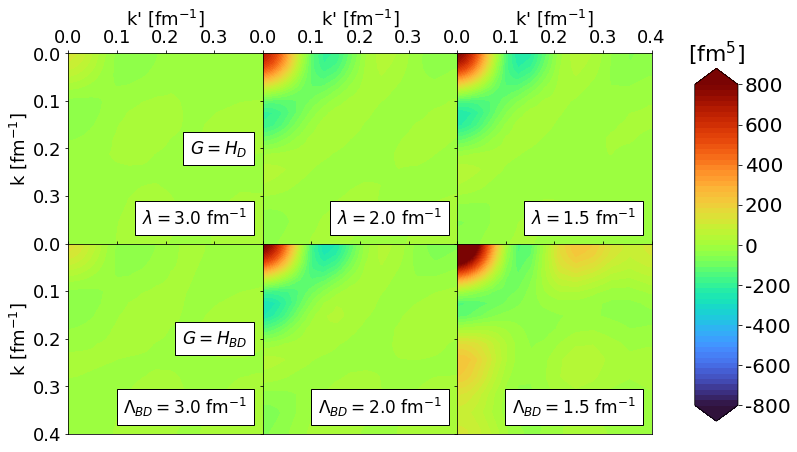

In [33]:
# Contours of r^2 operator (subtracting out initial operator) under RKE N4LO (450 MeV) transformations
kvnn = 111
#kvnn = 79
channel = '3S1'
lambda_array = np.array([3.0, 2.0, 1.5])
f, axs = r2_diff_contours(kvnn, generators, lambda_array)

# Add generator label to each subplot on the 1st column
generator_label_size = 17
generator_label_location = 'center right'
for i, generator in enumerate(generators):
    generator_label = ff.generator_label_conversion(generator)
    anchored_text = AnchoredText(generator_label, loc=generator_label_location,
                                 prop=dict(size=generator_label_size))
    axs[i, 0].add_artist(anchored_text)

# Add \lambda label to each sub-plot
lambda_label_size = 17
lambda_label_location = 'lower right'
for i, generator in enumerate(generators):
    for j, lamb in enumerate(lambda_array):
        if generator == 'Block-diag':
            # Labels the block-diagonal cutoff \Lambda_BD
            lambda_label = ff.lambda_label_conversion(lamb, block_diag_bool=True)
        else:
            # Labels the evolution parameter \lambda
            lambda_label = ff.lambda_label_conversion(lamb)
        anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size))
        axs[i, j].add_artist(anchored_text)

# Set file name
file_name = 'r2_diff_contours_kvnn_%d_%s' % (kvnn, channel)
file_name = ff.replace_periods_with_commas(file_name)
file_name += '.png'

# Save figure as .pdf
chdir('Figures/Operator_evolution')
f.savefig(file_name, bbox_inches='tight')
chdir(cwd)

In [34]:
def r2_diff_logscale(lambda_array, *transformations):
    
    
    # Check that at least one potential was provided
    if not transformations: 
        print('At least one SRG transformation must be specified.')
        return None
    
    
    # --- Set-up --- #
    
    # Specify r_array
    r_min = 0.005
    r_max = 30.2
    dr = 0.005
    r_array = np.arange(r_min, r_max + dr, dr)

    # Store kvnn values in this list
    kvnns = []
    channel = '3S1'
    # SRG generators
    generators = ['Wegner', 'Block-diag']
    
    # Size of figure
    row_number = 2
    col_number = 4
    figure_size = (4*col_number, 4*row_number) # (width, height)
    
    # Limits of x axis
    xlim = [0.0, 4.0]

    # Limits of axes on contours (units are fm^-1)
    axes_max = 5.0
    xlim = [0.0, axes_max]
    ylim = [1e-6, 1e4]
    
    # Fontsize for labels and tick marks
    x_label_size = 18
    y_label_size = 17
    legend_label_size = 15
    lambda_label_size = 17
    axes_tick_size = 16

    # Labels
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    y_diag_label = r'$|r^2_{\lambda}(k,k)-r^2_{\infty}(k,k)|$' + ' [fm' + r'$^4$' + ']'
    y_off_diag_label = r'$|r^2_{\lambda}(k,0)-r^2_{\infty}(k,0)|$' + ' [fm' + r'$^4$' + ']'
    wegner_label = ff.generator_label_conversion('Wegner')
    block_diag_label = ff.generator_label_conversion('Block-diag')
    # Label for lambda and Lambda_BD
    #lambda_label = r'$\lambda$' + ', ' + r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$'
    lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$'
        
    # Location of labels
    legend_label_location = 'upper right'
    lambda_label_location = 'lower left'
    
    # Line colors and styles
    kvnn_1_color = 'xkcd:black'
    kvnn_2_color = 'xkcd:red'
    kvnn_3_color = 'xkcd:blue'
    generator_1_style = 'solid'
    generator_2_style = 'dashed'
    
    # Initialize file name of figure
    file_name = 'r2_diff_logscale_kvnns'

    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data and store in dictionary --- #
    
    # Initialize dictionary
    d = {}
    
    # Loop over SRG-evolved potentials starting with the generator
    for generator in generators:
        
        d[generator] = {}
        
        # Next potential specifications
        for transformation in transformations:
        
            # Set kvnn, kmax, kmid, ntot, and generator
            kvnn = transformation[0]
            kmax = transformation[1]
            kmid = transformation[2]
            ntot = transformation[3]
            
            d[generator][kvnn] = {}
        
            # Keep track of kvnn numbers for file name at the end
            if kvnn not in kvnns:
                kvnns.append(kvnn)
            
            # Load initial Hamiltonian, momentum, and initial r^2 operator
            H_initial = lsp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
            k_array, k_weights = lsp.load_momentum(kvnn, channel, kmax, kmid, ntot)
            r2_matrix_init = op.r2_operator(k_array, k_weights, r_array, dr)[:ntot, :ntot]
            # spurious factor of pi?
            
            d[generator][kvnn]['k_array'] = k_array

            # Loop over lambda
            i = 0 # Sub-plot number
            for lamb in lambda_array:
                
                d[generator][kvnn][lamb] = {}

                # Load unitary transformations
                # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
                if generator == 'Block-diag':
                    H_evolved = lsp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, 1.0, lamb)
                else:
                    H_evolved = lsp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb)
                    
                # Calculate the unitary transformation
                U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
                
                # Evolved r^2 operator (spurious factor of pi?)
                r2_matrix_evolved = op.r2_operator(k_array, k_weights, r_array, dr, U_matrix)[:ntot, :ntot]
                
                # Difference in diagonal elements
                d[generator][kvnn][lamb]['diag'] = abs( np.diag(r2_matrix_evolved - r2_matrix_init) ) / np.sqrt(k_weights)
                # Difference in off-diagonal elements
                d[generator][kvnn][lamb]['off-diag'] = abs( r2_matrix_evolved[:, 0] - r2_matrix_init[:, 0] ) / np.sqrt(k_weights)
     
        
    # --- Plot and save figure --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Labels for potentials
    potential_label_1 = ff.kvnn_label_conversion(kvnns[0], full_label=False)
    potential_label_2 = ff.kvnn_label_conversion(kvnns[1], full_label=False)
    potential_label_3 = ff.kvnn_label_conversion(kvnns[2], full_label=False)
    
    # Row 1 #
    # Diagonal matrix elements
    
    # Sub-plot 1
    axs[0, 0].semilogy(d[generators[0]][kvnns[0]]['k_array'], d[generators[0]][kvnns[0]][lambda_array[0]]['diag'],
                       color=kvnn_1_color, linestyle=generator_1_style, label=potential_label_1)
    axs[0, 0].semilogy(d[generators[0]][kvnns[1]]['k_array'], d[generators[0]][kvnns[1]][lambda_array[0]]['diag'],
                       color=kvnn_2_color, linestyle=generator_1_style, label=potential_label_2)
    axs[0, 0].semilogy(d[generators[0]][kvnns[2]]['k_array'], d[generators[0]][kvnns[2]][lambda_array[0]]['diag'],
                       color=kvnn_3_color, linestyle=generator_1_style, label=potential_label_3)
#     axs[0, 0].semilogy(d[generators[1]][kvnns[0]]['k_array'], d[generators[1]][kvnns[0]][lambda_array[0]]['diag'],
#                        color=kvnn_1_color, linestyle=generator_2_style, label='')
#     axs[0, 0].semilogy(d[generators[1]][kvnns[1]]['k_array'], d[generators[1]][kvnns[1]][lambda_array[0]]['diag'],
#                        color=kvnn_2_color, linestyle=generator_2_style, label='')
#     axs[0, 0].semilogy(d[generators[1]][kvnns[2]]['k_array'], d[generators[1]][kvnns[2]][lambda_array[0]]['diag'],
#                        color=kvnn_3_color, linestyle=generator_2_style, label='')
    # Specify axes limits
    axs[0, 0].set_xlim(xlim)
    axs[0, 0].set_ylim(ylim)
    # Set tick labels size
    axs[0, 0].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping y-axis tick marks
    yticks_1 = axs[0, 0].yaxis.get_major_ticks()
    yticks_1[1].set_visible(False)
    # Set axes labels
    axs[0, 0].set_ylabel(y_diag_label, fontsize=y_label_size)
    # Set legend label
    axs[0, 0].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    # Add lambda label as anchored text
    #lambda_anchored_text_1 = AnchoredText(lambda_label % lambda_array[0], prop=dict(size=lambda_label_size),
                                          #loc=lambda_label_location, frameon=False)
    #axs[0, 0].add_artist(lambda_anchored_text_1)
    
    # Sub-plot 2
    axs[0, 1].semilogy(d[generators[0]][kvnns[0]]['k_array'], d[generators[0]][kvnns[0]][lambda_array[1]]['diag'],
                       color=kvnn_1_color, linestyle=generator_1_style, label=wegner_label)
    axs[0, 1].semilogy(d[generators[0]][kvnns[1]]['k_array'], d[generators[0]][kvnns[1]][lambda_array[1]]['diag'],
                       color=kvnn_2_color, linestyle=generator_1_style, label='')
    axs[0, 1].semilogy(d[generators[0]][kvnns[2]]['k_array'], d[generators[0]][kvnns[2]][lambda_array[1]]['diag'],
                       color=kvnn_3_color, linestyle=generator_1_style, label='')
#     axs[0, 1].semilogy(d[generators[1]][kvnns[0]]['k_array'], d[generators[1]][kvnns[0]][lambda_array[1]]['diag'],
#                        color=kvnn_1_color, linestyle=generator_2_style, label=block_diag_label)
#     axs[0, 1].semilogy(d[generators[1]][kvnns[1]]['k_array'], d[generators[1]][kvnns[1]][lambda_array[1]]['diag'],
#                        color=kvnn_2_color, linestyle=generator_2_style, label='')
#     axs[0, 1].semilogy(d[generators[1]][kvnns[2]]['k_array'], d[generators[1]][kvnns[2]][lambda_array[1]]['diag'],
#                        color=kvnn_3_color, linestyle=generator_2_style, label='')
    # Specify axes limits
    axs[0, 1].set_xlim(xlim)
    axs[0, 1].set_ylim(ylim)
    # Set tick labels size
    axs[0, 1].tick_params(labelsize=axes_tick_size)
    # Set legend label
    axs[0, 1].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    # Add lambda label as anchored text
    #lambda_anchored_text_2 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                          #loc=lambda_label_location, frameon=False)
    #axs[0, 1].add_artist(lambda_anchored_text_2)
    
    # Sub-plot 3
    axs[0, 2].semilogy(d[generators[0]][kvnns[0]]['k_array'], d[generators[0]][kvnns[0]][lambda_array[2]]['diag'],
                       color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 2].semilogy(d[generators[0]][kvnns[1]]['k_array'], d[generators[0]][kvnns[1]][lambda_array[2]]['diag'],
                       color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 2].semilogy(d[generators[0]][kvnns[2]]['k_array'], d[generators[0]][kvnns[2]][lambda_array[2]]['diag'],
                       color=kvnn_3_color, linestyle=generator_1_style)
#     axs[0, 2].semilogy(d[generators[1]][kvnns[0]]['k_array'], d[generators[1]][kvnns[0]][lambda_array[2]]['diag'],
#                        color=kvnn_1_color, linestyle=generator_2_style)
#     axs[0, 2].semilogy(d[generators[1]][kvnns[1]]['k_array'], d[generators[1]][kvnns[1]][lambda_array[2]]['diag'],
#                        color=kvnn_2_color, linestyle=generator_2_style)
#     axs[0, 2].semilogy(d[generators[1]][kvnns[2]]['k_array'], d[generators[1]][kvnns[2]][lambda_array[2]]['diag'],
#                        color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 2].set_xlim(xlim)
    axs[0, 2].set_ylim(ylim)
    # Set tick labels size
    axs[0, 2].tick_params(labelsize=axes_tick_size)
    # Add lambda label as anchored text
    #lambda_anchored_text_3 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                          #loc=lambda_label_location, frameon=False)
    #axs[0, 2].add_artist(lambda_anchored_text_3)
    
    # Sub-plot 4
    axs[0, 3].semilogy(d[generators[0]][kvnns[0]]['k_array'], d[generators[0]][kvnns[0]][lambda_array[3]]['diag'],
                       color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 3].semilogy(d[generators[0]][kvnns[1]]['k_array'], d[generators[0]][kvnns[1]][lambda_array[3]]['diag'],
                       color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 3].semilogy(d[generators[0]][kvnns[2]]['k_array'], d[generators[0]][kvnns[2]][lambda_array[3]]['diag'],
                       color=kvnn_3_color, linestyle=generator_1_style)
#     axs[0, 3].semilogy(d[generators[1]][kvnns[0]]['k_array'], d[generators[1]][kvnns[0]][lambda_array[3]]['diag'],
#                        color=kvnn_1_color, linestyle=generator_2_style)
#     axs[0, 3].semilogy(d[generators[1]][kvnns[1]]['k_array'], d[generators[1]][kvnns[1]][lambda_array[3]]['diag'],
#                        color=kvnn_2_color, linestyle=generator_2_style)
#     axs[0, 3].semilogy(d[generators[1]][kvnns[2]]['k_array'], d[generators[1]][kvnns[2]][lambda_array[3]]['diag'],
#                        color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 3].set_xlim(xlim)
    axs[0, 3].set_ylim(ylim)
    # Set tick labels size
    axs[0, 3].tick_params(labelsize=axes_tick_size)
    # Add lambda label as anchored text
    #lambda_anchored_text_4 = AnchoredText(lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                          #loc=lambda_label_location, frameon=False)
    #axs[0, 3].add_artist(lambda_anchored_text_4)
    
    # Row 2 #
    # Far off-diagonal matrix elements
    
    # Sub-plot 5
    axs[1, 0].semilogy(d[generators[0]][kvnns[0]]['k_array'], 
                       d[generators[0]][kvnns[0]][lambda_array[0]]['off-diag'], color=kvnn_1_color, 
                       linestyle=generator_1_style)
    axs[1, 0].semilogy(d[generators[0]][kvnns[1]]['k_array'],
                       d[generators[0]][kvnns[1]][lambda_array[0]]['off-diag'], color=kvnn_2_color,
                       linestyle=generator_1_style)
    axs[1, 0].semilogy(d[generators[0]][kvnns[2]]['k_array'],
                       d[generators[0]][kvnns[2]][lambda_array[0]]['off-diag'], color=kvnn_3_color,
                       linestyle=generator_1_style)
#     axs[1, 0].semilogy(d[generators[1]][kvnns[0]]['k_array'],
#                        d[generators[1]][kvnns[0]][lambda_array[0]]['off-diag'], color=kvnn_1_color,
#                        linestyle=generator_2_style)
#     axs[1, 0].semilogy(d[generators[1]][kvnns[1]]['k_array'],
#                        d[generators[1]][kvnns[1]][lambda_array[0]]['off-diag'], color=kvnn_2_color, 
#                        linestyle=generator_2_style, label='')
#     axs[1, 0].semilogy(d[generators[1]][kvnns[2]]['k_array'],
#                        d[generators[1]][kvnns[2]][lambda_array[0]]['off-diag'], color=kvnn_3_color, 
#                        linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 0].set_xlim(xlim)
    axs[1, 0].set_ylim(ylim)
    # Set tick labels size
    axs[1, 0].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_5 = axs[1, 0].xaxis.get_major_ticks()
    xticks_5[-1].set_visible(False)
    # Set axes labels
    axs[1, 0].set_xlabel(x_label, fontsize=x_label_size)
    axs[1, 0].set_ylabel(y_off_diag_label, fontsize=y_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_5 = AnchoredText(lambda_label % lambda_array[0], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[1, 0].add_artist(lambda_anchored_text_5)
    
    # Sub-plot 6
    axs[1, 1].semilogy(d[generators[0]][kvnns[0]]['k_array'], 
                       d[generators[0]][kvnns[0]][lambda_array[1]]['off-diag'], color=kvnn_1_color, 
                       linestyle=generator_1_style)
    axs[1, 1].semilogy(d[generators[0]][kvnns[1]]['k_array'],
                       d[generators[0]][kvnns[1]][lambda_array[1]]['off-diag'], color=kvnn_2_color,
                       linestyle=generator_1_style)
    axs[1, 1].semilogy(d[generators[0]][kvnns[2]]['k_array'],
                       d[generators[0]][kvnns[2]][lambda_array[1]]['off-diag'], color=kvnn_3_color,
                       linestyle=generator_1_style)
#     axs[1, 1].semilogy(d[generators[1]][kvnns[0]]['k_array'],
#                        d[generators[1]][kvnns[0]][lambda_array[1]]['off-diag'], color=kvnn_1_color,
#                        linestyle=generator_2_style)
#     axs[1, 1].semilogy(d[generators[1]][kvnns[1]]['k_array'],
#                        d[generators[1]][kvnns[1]][lambda_array[1]]['off-diag'], color=kvnn_2_color, 
#                        linestyle=generator_2_style, label='')
#     axs[1, 1].semilogy(d[generators[1]][kvnns[2]]['k_array'],
#                        d[generators[1]][kvnns[2]][lambda_array[1]]['off-diag'], color=kvnn_3_color, 
#                        linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 1].set_xlim(xlim)
    axs[1, 1].set_ylim(ylim)
    # Set tick labels size
    axs[1, 1].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_6 = axs[1, 1].xaxis.get_major_ticks()
    xticks_6[-1].set_visible(False)
    # Set axes labels
    axs[1, 1].set_xlabel(x_label, fontsize=x_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_6 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[1, 1].add_artist(lambda_anchored_text_6)
    
    # Sub-plot 7
    axs[1, 2].semilogy(d[generators[0]][kvnns[0]]['k_array'], 
                       d[generators[0]][kvnns[0]][lambda_array[2]]['off-diag'], color=kvnn_1_color, 
                       linestyle=generator_1_style)
    axs[1, 2].semilogy(d[generators[0]][kvnns[1]]['k_array'],
                       d[generators[0]][kvnns[1]][lambda_array[2]]['off-diag'], color=kvnn_2_color,
                       linestyle=generator_1_style)
    axs[1, 2].semilogy(d[generators[0]][kvnns[2]]['k_array'],
                       d[generators[0]][kvnns[2]][lambda_array[2]]['off-diag'], color=kvnn_3_color,
                       linestyle=generator_1_style)
#     axs[1, 2].semilogy(d[generators[1]][kvnns[0]]['k_array'],
#                        d[generators[1]][kvnns[0]][lambda_array[2]]['off-diag'], color=kvnn_1_color,
#                        linestyle=generator_2_style)
#     axs[1, 2].semilogy(d[generators[1]][kvnns[1]]['k_array'],
#                        d[generators[1]][kvnns[1]][lambda_array[2]]['off-diag'], color=kvnn_2_color, 
#                        linestyle=generator_2_style, label='')
#     axs[1, 2].semilogy(d[generators[1]][kvnns[2]]['k_array'],
#                        d[generators[1]][kvnns[2]][lambda_array[2]]['off-diag'], color=kvnn_3_color, 
#                        linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 2].set_xlim(xlim)
    axs[1, 2].set_ylim(ylim)
    # Set tick labels size
    axs[1, 2].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_7 = axs[1, 2].xaxis.get_major_ticks()
    xticks_7[-1].set_visible(False)
    # Set axes labels
    axs[1, 2].set_xlabel(x_label, fontsize=x_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_7 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[1, 2].add_artist(lambda_anchored_text_7)
    
    # Sub-plot 8
    axs[1, 3].semilogy(d[generators[0]][kvnns[0]]['k_array'], 
                       d[generators[0]][kvnns[0]][lambda_array[3]]['off-diag'], color=kvnn_1_color, 
                       linestyle=generator_1_style)
    axs[1, 3].semilogy(d[generators[0]][kvnns[1]]['k_array'],
                       d[generators[0]][kvnns[1]][lambda_array[3]]['off-diag'], color=kvnn_2_color,
                       linestyle=generator_1_style)
    axs[1, 3].semilogy(d[generators[0]][kvnns[2]]['k_array'],
                       d[generators[0]][kvnns[2]][lambda_array[3]]['off-diag'], color=kvnn_3_color,
                       linestyle=generator_1_style)
#     axs[1, 3].semilogy(d[generators[1]][kvnns[0]]['k_array'],
#                        d[generators[1]][kvnns[0]][lambda_array[3]]['off-diag'], color=kvnn_1_color,
#                        linestyle=generator_2_style)
#     axs[1, 3].semilogy(d[generators[1]][kvnns[1]]['k_array'],
#                        d[generators[1]][kvnns[1]][lambda_array[3]]['off-diag'], color=kvnn_2_color, 
#                        linestyle=generator_2_style, label='')
#     axs[1, 3].semilogy(d[generators[1]][kvnns[2]]['k_array'],
#                        d[generators[1]][kvnns[2]][lambda_array[3]]['off-diag'], color=kvnn_3_color, 
#                        linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 3].set_xlim(xlim)
    axs[1, 3].set_ylim(ylim)
    # Set tick labels size
    axs[1, 3].tick_params(labelsize=axes_tick_size)
    # Set axes labels
    axs[1, 3].set_xlabel(x_label, fontsize=x_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_8 = AnchoredText(lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[1, 3].add_artist(lambda_anchored_text_8)
    
    
    # --- Set figure specifications and save --- #

    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Show plot in notebook
    plt.show()

In [35]:
# def r2_diag_diff(generator, lambda_array):
def r2_diag_diff(generator, kvnns, lambda_array):
    """
    Plots the difference in the diagonal elements of the r^2 operator [fm^5] between SRG transformations with
    respect to momentum [fm^-1]. This is an 1 x n contour plot where n is the size of lambda_array.
    
    Parameters
    ----------
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (79, 111, 222)).
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """

    
    # --- Set-up --- #
    
    # Partial wave channel
    channel = '3S1'
    
    # Specify r_array
    r_min = 0.005
    r_max = 30.2
    dr = 0.005
    r_array = np.arange(r_min, r_max + dr, dr)

    # Size of figure
    row_number = 1
    col_number = len(lambda_array)
    figure_size = (4*col_number, 4*row_number)
    
    # Axes limits
    #k_max = 5.0
    k_max = 0.2
#     k_max = 10.0
    xlim = [0.0, k_max]
    delta_r2_min = -1e3
    delta_r2_max = 3e3
#     delta_r2_min = -3.5e5
#     delta_r2_max = 3e5
#     delta_r2_min = -1e9
#     delta_r2_max = 1e9
    ylim = [delta_r2_min, delta_r2_max]
   
    # Axes ticks, labels, and fontsizes
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = r'$\Delta r^2_{\lambda}$' + '(k,k) [fm' + r'$^5$' + ']'
    y_label_size = 20
#     x_stepsize = 1.0
    x_stepsize = 0.05
    # x axis ticks
    x_ticks = np.arange(0.0, xlim[1] + x_stepsize, x_stepsize)
    axes_tick_size = 14
    
    # Curve width
    curve_width = 2.0


    # --- Load operators --- #
    
    # Initialize dictionary to store difference in operators
    d = {}
    
    # Loop over kvnns
    for kvnn in kvnns:
#     blah = [(10, 10.0, 2.0, 120), (10, 30.0, 4.0, 120)]
#     for ele in blah:
#         kvnn = ele[0]
#         kmax = ele[1]
#         kmid = ele[2]
#         ntot = ele[3]
        
        # Store momentum and difference in here
        d[kvnn] = {}
#         d[kmax]={}
        
        # Load momentum and weights, and Hamiltonian
        k_array, k_weights = lsp.load_momentum(kvnn, channel)
#         k_array, k_weights = lsp.load_momentum(kvnn, channel, kmax, kmid, ntot)
        factor_array = np.concatenate( (k_array * np.sqrt(k_weights), k_array * np.sqrt(k_weights)) ) * 2/np.pi
        row, col = np.meshgrid(factor_array, factor_array)
        ntot = len(k_array)
        H_initial = lsp.load_hamiltonian(kvnn, channel)
#         H_initial = lsp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
        
#         d[kvnn]['k_array'] = k_array
#         d[kmax]['k_array']=k_array
        
        # Calculate initial operator
        initial_operator = op.r2_operator(k_array, k_weights, r_array, dr) / row / col
        k_array_int, initial_operator_int = ff.interpolate_matrix(k_array, initial_operator, k_max)
        
        # Loop over \lambda values
        for lamb in lambda_array:
            
            # Load unitary transformation
            # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
            if generator == 'Block-diag':
                H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=1.0, 
                                                 lambda_bd=lamb)
            else:
                H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb)
#                 H_evolved = lsp.load_hamiltonian(kvnn, channel, kmax=kmax, kmid=kmid, ntot=ntot, method='srg',
#                                                  generator=generator, lamb=lamb)
            U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
            # Evolved operator and difference from initial
            evolved_operator = op.r2_operator(k_array, k_weights, r_array, dr, U_matrix) / row / col
            k_array_int, evolved_operator_int = ff.interpolate_matrix(k_array, evolved_operator, k_max)
            operator_diff = evolved_operator_int - initial_operator_int
            # Interpolate
#             k_array_int, operator_diff_int = ff.interpolate_matrix(k_array, operator_diff, k_max)
            
            # Store difference in dictionary
            d[kvnn][lamb] = np.diag(operator_diff)
#             d[kvnn][lamb] = np.diag(operator_diff_int)
#             d[kmax][lamb] = np.diag(operator_diff)[:ntot]
            d[kvnn]['k_array'] = k_array_int
            
            
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over lambda's and kvnns keeping track of indices
    for i, lamb in enumerate(lambda_array):
        for j, kvnn in enumerate(kvnns):
#         for j, ele in enumerate(blah):
#             kmax = ele[1]
            
            # Curve color, styles, and labels
            curve_color = ff.xkcd_colors(j)
            curve_style = ff.line_styles(j)
            curve_label = ff.kvnn_label_conversion(kvnn) # Labels kvnn
#             curve_label = r'$k_{max}=%.1f$'%kmax
        
            axs[i].plot(d[kvnn]['k_array'], d[kvnn][lamb], color=curve_color, label=curve_label,
                        linestyle=curve_style, linewidth=curve_width)
#             axs[i].plot(d[kmax]['k_array'], d[kmax][lamb], color=curve_color, label=curve_label, 
#                         linestyle=curve_style, linewidth=curve_width)
            
        # Specify axes limits
        axs[i].set_xlim(xlim)
        axs[i].set_ylim(ylim)
        
        # Specify axes tick marks
        axs[i].xaxis.set_ticks(x_ticks)
        axs[i].tick_params(labelsize=axes_tick_size)
        
        # Prevent overlapping x-axis tick marks
        if i < col_number - 1:
            xticks = axs[i].xaxis.get_major_ticks()
            xticks[-1].set_visible(False)
    
        # Set axes labels
        axs[i].set_xlabel(x_label, fontsize=x_label_size)
        # Only set y-label for 1st sub-plot
        if i == 0:
            axs[i].set_ylabel(y_label, fontsize=y_label_size)
        
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    
    return f, axs

In [36]:
# # Difference in r^2 operator far off-diagonal elements under SRG transformations
# channel = '3S1'
# generator = 'Wegner'
# lambda_array = np.array([3.0, 2.0, 1.5])
# f, axs = r2_diag_diff(generator, kvnns_default, lambda_array)
# # f, axs = r2_diag_diff(generator, lambda_array)

# # Add legend for kvnns on 1st sub-plot
# legend_size = 16
# legend_location = 'upper right'
# axs[0].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'lower left'
# for i, lamb in enumerate(lambda_array):
#     if generator == 'Block-diag':
#         # Labels the block-diagonal cutoff \Lambda_BD
#         lambda_label = ff.lambda_label_conversion(lamb, block_diag_bool=True)
#     else:
#         # Labels the evolution parameter \lambda
#         lambda_label = ff.lambda_label_conversion(lamb)
#     anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size),
#                                  frameon=False)
#     axs[i].add_artist(anchored_text)

# # Set file name
# file_name = 'r2_diag_diff_%s_kvnns' % generator
# for kvnn in kvnns_default:
#     file_name += '_%d' % kvnn
# file_name += '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [37]:
# def r2_off_diag_diff(generator, lambda_array):
def r2_off_diag_diff(generator, kvnns, lambda_array):
    """
    Plots the difference in the far off-diagonal elements of the r^2 operator [fm^5] between SRG transformations 
    with respect to momentum [fm^-1]. This is an 1 x n contour plot where n is the size of lambda_array.
    
    Parameters
    ----------
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (79, 111, 222)).
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """

    
    # --- Set-up --- #
    
    # Partial wave channel
    channel = '3S1'
    
    # Specify r_array
    r_min = 0.005
    r_max = 30.2
    dr = 0.005
    r_array = np.arange(r_min, r_max + dr, dr)

    # Size of figure
    row_number = 1
    col_number = len(lambda_array)
    figure_size = (4*col_number, 4*row_number)
    
    # Axes limits
    #k_max = 5.0
    k_max = 0.4
#     k_max = 10.0
    xlim = [0.0, k_max]
    delta_r2_min = -1.5e3
    delta_r2_max = 3e3
#     delta_r2_min = -3.5e5
#     delta_r2_max = 3e5
#     delta_r2_min = -1e9
#     delta_r2_max = 1e9
    ylim = [delta_r2_min, delta_r2_max]
   
    # Axes ticks, labels, and fontsizes
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = r'$\Delta r^2_{\lambda}$' + '(k,0) [fm' + r'$^5$' + ']'
    y_label_size = 20
#     x_stepsize = 1.0
    x_stepsize = 0.1
    # x axis ticks
    x_ticks = np.arange(0.0, xlim[1] + x_stepsize, x_stepsize)
    axes_tick_size = 14
    
    # Curve width
    curve_width = 2.0


    # --- Load operators --- #
    
    # Initialize dictionary to store difference in operators
    d = {}
    
    # Loop over kvnns
    for kvnn in kvnns:
#     blah = [(10, 10.0, 2.0, 120), (10, 30.0, 4.0, 120)]
#     for ele in blah:
#         kvnn = ele[0]
#         kmax = ele[1]
#         kmid = ele[2]
#         ntot = ele[3]
        
        # Store momentum and difference in here
        d[kvnn] = {}
#         d[kmax]={}
        
        # Load momentum and weights, and Hamiltonian
        k_array, k_weights = lsp.load_momentum(kvnn, channel)
#         k_array, k_weights = lsp.load_momentum(kvnn, channel, kmax, kmid, ntot)
        factor_array = np.concatenate( (k_array * np.sqrt(k_weights), k_array * np.sqrt(k_weights)) ) * 2/np.pi
        row, col = np.meshgrid(factor_array, factor_array)
        ntot = len(k_array)
        H_initial = lsp.load_hamiltonian(kvnn, channel)
#         H_initial = lsp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
        
#         d[kvnn]['k_array'] = k_array
#         d[kmax]['k_array']=k_array
        
        # Calculate initial operator
        initial_operator = op.r2_operator(k_array, k_weights, r_array, dr) / row / col
        k_array_int, initial_operator_int = ff.interpolate_matrix(k_array, initial_operator, k_max)
        
        # Loop over \lambda values
        for lamb in lambda_array:
            
            # Load unitary transformation
            # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
            if generator == 'Block-diag':
                H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=1.0, 
                                                 lambda_bd=lamb)
            else:
                H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb)
#                 H_evolved = lsp.load_hamiltonian(kvnn, channel, kmax=kmax, kmid=kmid, ntot=ntot, method='srg',
#                                                  generator=generator, lamb=lamb)
            U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
            # Evolved operator and difference from initial
            evolved_operator = op.r2_operator(k_array, k_weights, r_array, dr, U_matrix) / row / col
            k_array_int, evolved_operator_int = ff.interpolate_matrix(k_array, evolved_operator, k_max)
            operator_diff = evolved_operator_int - initial_operator_int
            # Interpolate
#             k_array_int, operator_diff_int = ff.interpolate_matrix(k_array, operator_diff, k_max)
            
            # Store difference in dictionary
            d[kvnn][lamb] = operator_diff[:, 0]
#             d[kmax][lamb] = np.diag(operator_diff)[:ntot]
            d[kvnn]['k_array'] = k_array_int
            
            
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over lambda's and kvnns keeping track of indices
    for i, lamb in enumerate(lambda_array):
        for j, kvnn in enumerate(kvnns):
#         for j, ele in enumerate(blah):
#             kmax = ele[1]
            
            # Curve color, styles, and labels
            curve_color = ff.xkcd_colors(j)
            curve_style = ff.line_styles(j)
            curve_label = ff.kvnn_label_conversion(kvnn) # Labels kvnn
#             curve_label = r'$k_{max}=%.1f$'%kmax
        
            axs[i].plot(d[kvnn]['k_array'], d[kvnn][lamb], color=curve_color, label=curve_label,
                        linestyle=curve_style, linewidth=curve_width)
#             axs[i].plot(d[kmax]['k_array'], d[kmax][lamb], color=curve_color, label=curve_label, 
#                         linestyle=curve_style, linewidth=curve_width)
            
        # Specify axes limits
        axs[i].set_xlim(xlim)
        axs[i].set_ylim(ylim)
        
        # Specify axes tick marks
        axs[i].xaxis.set_ticks(x_ticks)
        axs[i].tick_params(labelsize=axes_tick_size)
        
        # Prevent overlapping x-axis tick marks
        if i < col_number - 1:
            xticks = axs[i].xaxis.get_major_ticks()
            xticks[-1].set_visible(False)
    
        # Set axes labels
        axs[i].set_xlabel(x_label, fontsize=x_label_size)
        # Only set y-label for 1st sub-plot
        if i == 0:
            axs[i].set_ylabel(y_label, fontsize=y_label_size)
        
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    
    return f, axs

In [38]:
# # Difference in r^2 operator far off-diagonal elements under SRG transformations
# channel = '3S1'
# generator = 'Wegner'
# lambda_array = np.array([3.0, 2.0, 1.5])
# f, axs = r2_off_diag_diff(generator, kvnns_default, lambda_array)
# # f, axs = r2_off_diag_diff(generator, lambda_array)

# # Add legend for kvnns on 1st sub-plot
# legend_size = 16
# legend_location = 'upper right'
# axs[0].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'lower left'
# for i, lamb in enumerate(lambda_array):
#     if generator == 'Block-diag':
#         # Labels the block-diagonal cutoff \Lambda_BD
#         lambda_label = ff.lambda_label_conversion(lamb, block_diag_bool=True)
#     else:
#         # Labels the evolution parameter \lambda
#         lambda_label = ff.lambda_label_conversion(lamb)
#     anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size),
#                                  frameon=False)
#     axs[i].add_artist(anchored_text)

# # Set file name
# file_name = 'r2_off_diag_diff_%s_kvnns' % generator
# for kvnn in kvnns_default:
#     file_name += '_%d' % kvnn
# file_name += '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [39]:
def r2_integrand_contours(kvnn, generator, lamb, eps=-2.22, lambda_bd=0.0, scale='linear'):
        
    channel = '3S1'
    # Load initial Hamiltonian, momentum, and weights
    k_array, k_weights = lsp.load_momentum(kvnn, channel)
    ntot = len(k_array)
    # The arrays below are used later to present a mesh-independent result
    factor_array = np.concatenate( (k_array * np.sqrt(k_weights), k_array * np.sqrt(k_weights)) ) * np.sqrt(2/np.pi)
    row, col = np.meshgrid(factor_array, factor_array)
    
    H_initial = lsp.load_hamiltonian(kvnn, channel)
    H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb,
                                     lambda_bd=lambda_bd)
    U_matrix = SRG_unitary_transformation(H_initial, H_evolved)

    # Specify r_array
    r_min = 0.005
    r_max = 30.2
    dr = 0.005
    r_array = np.arange(r_min, r_max + dr, dr)
    
    # Labels
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    # Label the block-diagonal Lambda
    if generator == 'Block-diag':
        lambda_label = r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$'
    # For band-diagonal generators, label lambda
    else:
        lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$'
    generator_label = ff.generator_label_conversion(generator)
    
    # Fontsize for labels and tick marks
    axes_label_size = 18
    lambda_label_size = 17
    generator_label_size = 17
    colorbar_label_size = 20
    axes_tick_size = 18
    colorbar_tick_size = 18

    # Limits of axes on contours (units are fm^-1)
    if scale == 'linear':
        axes_max = 1.0
        axes_lim = [0.0, axes_max]
        # Specifications of x and y axes
        # Step-size in labeling tick marks
        axes_stepsize = 0.25
    else:
        axes_max = 5.0
        axes_lim = [0.0, axes_max]
        # Specifications of x and y axes
        # Step-size in labeling tick marks
        axes_stepsize = 1.0
    # x and y axes ticks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)

    # Limits of colorbar (units are fm^6)
    if scale == 'linear':
        mx = 3000
        mn = -3000
        color_style = 'jet'
    else:
        mx = 1e3
        mn = 1e-7
        colorbar_norm_log = colors.LogNorm(vmin=mn, vmax=mx)
        color_style = 'Blues'

    # Size of figure
    figure_size = (4, 3.5) # (width, height) - extra width for colorbar
    
    # File name of figure
    # This reads 'momentum_projection_contours_kvnn_number_generator'
    file_name = 'r2_integrand_contours_kvnn%d_%s_eps%.2f_lamb%.1f' % (kvnn, generator, eps, lamb)
    if generator=='Block-diag':
        file_name += 'lambda_bd%.1f' % lambda_bd
    file_name += '_%s' % scale

    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data and plot contours --- #
    
    # Evolved momentum projection operator
    operator = op.r2_operator(k_array, k_weights, r_array, dr, U_matrix)
    # Divide by k_i * k_j * sqrt( w_i * w_j ) for mesh-independent result
    #operator = operator / row / col
    #operator = operator / np.pi
    
    psi = ob.wave_function(H_initial, eps=eps, U=U_matrix)
    psi_with_weights = psi * factor_array
    
    psi_row, psi_col = np.meshgrid(psi_with_weights, psi_with_weights)
    
    integrand = psi_row * operator * psi_col / row / col
    if scale == 'log':
        integrand = abs(integrand)
        
    # Interpolate the operator through 0 to axes_max for smoother looking figure (the extension _int means 
    # interpolated)
    k_array_int, integrand_int = ff.interpolate_matrix(k_array, integrand, axes_max)
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    if scale == 'linear':
        c = ax.pcolormesh(k_array_int, k_array_int, integrand_int, cmap=color_style, vmin=mn, vmax=mx,
                          rasterized=True)
    else:
        c = ax.pcolormesh(k_array_int, k_array_int, integrand_int, cmap=color_style, norm=colorbar_norm_log,
                          rasterized=True)
                                         
    # Specify axes limits
    ax.set_xlim( axes_lim )
    ax.set_ylim( axes_lim )
                     
    ax.xaxis.set_ticks(axes_ticks)
    ax.xaxis.set_ticklabels(axes_ticks)
    # Switch from bottom to top
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    ax.tick_params(labeltop=True, labelsize=axes_tick_size)

    # Set x-axis label
    ax.set_xlabel(x_label, fontsize=axes_label_size)
    # Specify axes tick marks
    ax.yaxis.set_ticks(axes_ticks)
    ax.yaxis.set_ticklabels(axes_ticks)
    ax.tick_params(labelsize=axes_tick_size)
    # Set y-axis label
    ax.set_ylabel(y_label, fontsize=axes_label_size)
    
    generator_label_size = 17
    generator_label_location = 'upper right'
    generator_label = ff.generator_label_conversion(generator)
    generator_anchored_text = AnchoredText(generator_label, loc=generator_label_location,
                                           prop=dict(size=generator_label_size))
    ax.add_artist(generator_anchored_text)

    # Add \lambda label to each sub-plot
    lambda_label_size = 17
    lambda_label_location = 'lower left'
    if generator == 'Block-diag':
        # Labels the block-diagonal cutoff \Lambda_BD
        lambda_label = ff.lambda_label_conversion(lambda_bd, block_diag_bool=True)
    else:
        # Labels the evolution parameter \lambda
        lambda_label = ff.lambda_label_conversion(lamb)
    lambda_anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size))
    ax.add_artist(lambda_anchored_text)
    
    # Invert y-axis
    plt.gca().invert_yaxis()
                                         
    # Set colorbar axe
    f.subplots_adjust(right=0.8) # Adjust for colorbar space
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    
    plt.show()
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

    return f, ax

In [40]:
def r2_integrand_diff_contours(kvnn_1, kvnn_2, generator, lamb, eps=-2.22, lambda_bd=0.0, scale='linear'):
        
    channel = '3S1'
    # Load initial Hamiltonian, momentum, and weights
    k_array_1, k_weights_1 = lsp.load_momentum(kvnn_1, channel)
    k_array_2, k_weights_2 = lsp.load_momentum(kvnn_2, channel)
    ntot = len(k_array_1)
    # The arrays below are used later to present a mesh-independent result
    factor_array_1 = np.concatenate( (k_array_1 * np.sqrt(k_weights_1), k_array_1 * np.sqrt(k_weights_1)) ) * \
                     np.sqrt(2/np.pi)
    row_1, col_1 = np.meshgrid(factor_array_1, factor_array_1)
    factor_array_2 = np.concatenate( (k_array_2 * np.sqrt(k_weights_2), k_array_2 * np.sqrt(k_weights_2)) ) * \
                     np.sqrt(2/np.pi)
    row_2, col_2 = np.meshgrid(factor_array_2, factor_array_2)
    
    H_initial_1 = lsp.load_hamiltonian(kvnn_1, channel)
    H_evolved_1 = lsp.load_hamiltonian(kvnn_1, channel, method='srg', generator=generator, lamb=lamb,
                                       lambda_bd=lambda_bd)
    U_matrix_1 = SRG_unitary_transformation(H_initial_1, H_evolved_1)
    H_initial_2 = lsp.load_hamiltonian(kvnn_2, channel)
    H_evolved_2 = lsp.load_hamiltonian(kvnn_2, channel, method='srg', generator=generator, lamb=lamb,
                                       lambda_bd=lambda_bd)
    U_matrix_2 = SRG_unitary_transformation(H_initial_2, H_evolved_2)

    # Specify r_array
    r_min = 0.005
    r_max = 30.2
    dr = 0.005
    r_array = np.arange(r_min, r_max + dr, dr)
    
    # Labels
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    # Label the block-diagonal Lambda
    if generator == 'Block-diag':
        lambda_label = r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$'
    # For band-diagonal generators, label lambda
    else:
        lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$'
    generator_label = ff.generator_label_conversion(generator)
    
    # Fontsize for labels and tick marks
    axes_label_size = 18
    lambda_label_size = 17
    generator_label_size = 17
    colorbar_label_size = 20
    axes_tick_size = 18
    colorbar_tick_size = 18

    # Limits of axes on contours (units are fm^-1)
    if scale == 'linear':
        axes_max = 1.0
        axes_lim = [0.0, axes_max]
        # Specifications of x and y axes
        # Step-size in labeling tick marks
        axes_stepsize = 0.25
    else:
        axes_max = 5.0
        axes_lim = [0.0, axes_max]
        # Specifications of x and y axes
        # Step-size in labeling tick marks
        axes_stepsize = 1.0
    # x and y axes ticks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)

    # Limits of colorbar (units are fm^6)
    if scale == 'linear':
        mx = 10
        mn = -10
        color_style = 'jet'
    else:
        mx = 1e2
        mn = 1e-8
        colorbar_norm_log = colors.LogNorm(vmin=mn, vmax=mx)
        color_style = 'Blues'

    # Size of figure
    figure_size = (4, 3.5) # (width, height) - extra width for colorbar
    
    # File name of figure
    # This reads 'momentum_projection_contours_kvnn_number_generator'
    file_name = 'r2_integrand_diff_contours_kvnns_%d_%d_%s_eps%.2f_lamb%.1f' % \
                (kvnn_1, kvnn_2, generator, eps, lamb)
    if generator=='Block-diag':
        file_name += 'lambda_bd%.1f' % lambda_bd
    file_name += '_%s' % scale

    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data and plot contours --- #
    
    # Evolved momentum projection operator
    operator_1 = op.r2_operator(k_array_1, k_weights_1, r_array, dr, U_matrix_1)
    operator_2 = op.r2_operator(k_array_2, k_weights_2, r_array, dr, U_matrix_2)
    # Divide by k_i * k_j * sqrt( w_i * w_j ) for mesh-independent result
    #operator = operator / row / col
    #operator = operator / np.pi
    
    psi_1 = ob.wave_function(H_initial_1, eps=eps, U=U_matrix_1)
    psi_with_weights_1 = psi_1 * factor_array_1
    psi_2 = ob.wave_function(H_initial_2, eps=eps, U=U_matrix_2)
    psi_with_weights_2 = psi_2 * factor_array_2
    
    psi_row_1, psi_col_1 = np.meshgrid(psi_with_weights_1, psi_with_weights_1)
    psi_row_2, psi_col_2 = np.meshgrid(psi_with_weights_2, psi_with_weights_2)
    
    integrand_1 = psi_row_1 * operator_1 * psi_col_1 / row_1 / col_1
    integrand_2 = psi_row_2 * operator_2 * psi_col_2 / row_2 / col_2
    if scale == 'log':
        integrand_diff = abs(integrand_1-integrand_2)
    else:
        integrand_diff = integrand_1 - integrand_2
         
    # Interpolate the operator through 0 to axes_max for smoother looking figure (the extension _int means 
    # interpolated)
    k_array_int, integrand_diff_int = ff.interpolate_matrix(k_array_1, integrand_diff, axes_max)
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    if scale == 'linear':
        c = ax.pcolormesh(k_array_int, k_array_int, integrand_diff_int, cmap=color_style, vmin=mn, vmax=mx,
                          rasterized=True)
    else:
        c = ax.pcolormesh(k_array_int, k_array_int, integrand_diff_int, cmap=color_style, norm=colorbar_norm_log,
                          rasterized=True)
                                         
    # Specify axes limits
    ax.set_xlim( axes_lim )
    ax.set_ylim( axes_lim )
                     
    ax.xaxis.set_ticks(axes_ticks)
    ax.xaxis.set_ticklabels(axes_ticks)
    # Switch from bottom to top
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    ax.tick_params(labeltop=True, labelsize=axes_tick_size)

    # Set x-axis label
    ax.set_xlabel(x_label, fontsize=axes_label_size)
    # Specify axes tick marks
    ax.yaxis.set_ticks(axes_ticks)
    ax.yaxis.set_ticklabels(axes_ticks)
    ax.tick_params(labelsize=axes_tick_size)
    # Set y-axis label
    ax.set_ylabel(y_label, fontsize=axes_label_size)
    
    generator_label_size = 17
    generator_label_location = 'upper right'
    generator_label = ff.generator_label_conversion(generator)
    generator_anchored_text = AnchoredText(generator_label, loc=generator_label_location,
                                           prop=dict(size=generator_label_size))
    ax.add_artist(generator_anchored_text)

    # Add \lambda label to each sub-plot
    lambda_label_size = 17
    lambda_label_location = 'lower right'
    if generator == 'Block-diag':
        # Labels the block-diagonal cutoff \Lambda_BD
        lambda_label = ff.lambda_label_conversion(lambda_bd, block_diag_bool=True)
    else:
        # Labels the evolution parameter \lambda
        lambda_label = ff.lambda_label_conversion(lamb)
    lambda_anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size))
    ax.add_artist(lambda_anchored_text)
    
    # Invert y-axis
    plt.gca().invert_yaxis()
                                         
    # Set colorbar axe
    f.subplots_adjust(right=0.8) # Adjust for colorbar space
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    
    plt.show()
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

    return f, ax

In [41]:
# f, ax = r2_integrand_contours(79, 'Wegner', 1.5)
# f, ax = r2_integrand_contours(111, 'Wegner', 1.5)
# f, ax = r2_integrand_contours(222, 'Wegner', 1.5)
# f, ax = r2_integrand_contours(111, 'Wegner', 3.0, eps=-2.22, scale='log')
# f, ax = r2_integrand_contours(111, 'Wegner', 1.5, eps=-2.22, scale='log')
# f, ax = r2_integrand_contours(111, 'Block-diag', 1.0, eps=-2.22, lambda_bd=3.0, scale='log')
# f, ax = r2_integrand_contours(111, 'Block-diag', 1.0, eps=-2.22, lambda_bd=2.0, scale='log')

# f, ax = r2_integrand_contours(111, 'Wegner', 3.0, eps=300.0, scale='log')
# f, ax = r2_integrand_contours(111, 'Wegner', 1.5, eps=300.0, scale='log')
# f, ax = r2_integrand_contours(111, 'Block-diag', 1.0, eps=300.0, lambda_bd=3.0, scale='log')
# f, ax = r2_integrand_contours(111, 'Block-diag', 1.0, eps=300.0, lambda_bd=2.0, scale='log')

# f, ax = r2_integrand_diff_contours(79, 111, 'Wegner', 1.5, eps=-2.22, scale='linear')
# f, ax = r2_integrand_diff_contours(79, 222, 'Wegner', 1.5, eps=-2.22, scale='linear')
# f, ax = r2_integrand_diff_contours(111, 222, 'Wegner', 1.5, eps=-2.22, scale='linear')
# f, ax = r2_integrand_diff_contours(79, 111, 'Block-diag', 1.0, eps=-2.22, lambda_bd=2.0, scale='linear')

__Plot SRG transformations $\delta U_{\lambda}(k,k')=U_{\lambda}(k,k')-1$__

In [42]:
def unitary_transformation_contours(channel, generator, kvnns, lamb, lambda_bd=0.00, contour_type='contourf'):
    """
    Plots SRG unitary transformations [fm^3] with respect to momentum [fm^-1]. This is an 2 x n contour plot where
    n is the size of kvnns.
    
    Parameters
    ----------
    channel : str
        The partial wave channel (e.g. '1S0').
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (79, 111, 222)).
    lamb : float
        Evolution parameter lambda [fm^-1].
    lambda_bd : float, optional
        Lambda value for block-diagonal decoupling [fm^-1].
    contour_type : str, optional
        If 'contourf' uses matplotlib's contourf plotting function. Otherwise, uses matplotlib's pcolormesh.

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """
    
    
    # --- Set-up --- #
    
    # Size of figure
    row_number = 2
    col_number = len(kvnns)
    figure_size = (4*col_number, 3.5*row_number) # Extra width for colorbar
    
    # Axes limits
    axes_max = 5.0
    axes_lim = [0.0, axes_max]
    
    # Axes ticks, labels, and fontsizes
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    axes_stepsize = 1.0 # Step-size in labeling tick marks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    axes_tick_size = 18
    
    # Colorbar ticks, label, and fontsize
    levels_number = 61
    # Linear scale settings
    mx_lin = 0.2
    mn_lin = -0.2
    colorbar_norm_lin = colors.Normalize(vmin=mn_lin, vmax=mx_lin)
    levels_lin = np.linspace(mn_lin, mx_lin, levels_number)
    levels_lin_ticks = np.linspace(mn_lin, mx_lin, 5)
    levels_lin_ticks_strings = ['%.1f' % tick for tick in levels_lin_ticks]
    # Log scale settings
    mx_log = 0
    mn_log = -4
    levels_log = np.logspace(mn_log, mx_log, levels_number)
    levels_log_ticks = np.logspace(mn_log, mx_log, 5)
    levels_log_ticks_strings = [r'$10^{%d}$' % step for step in range(mn_log, mx_log+1)]
    colorbar_norm_log = colors.LogNorm(vmin=mn_log, vmax=mx_log)
    # Colorbar label
    colorbar_label = '[fm' +r'$^3$' + ']'
    colorbar_label_size = 20
    colorbar_tick_size = 15

    # Color scheme for contour plots
    color_style_lin = 'turbo'
    color_style_log = 'Blues'

    
    # --- Load transformations --- #
    
    # Initialize dictionary to store evolved potentials and momentum arrays
    d = {}
    
    # Loop over kvnns
    for kvnn in kvnns:
        
        # Store momentum and transformation in here
        d[kvnn] = {}
        
        # Load momentum and weights, initial Hamiltonian, and build factor_array for dividing out momentum and 
        # weights
        k_array, k_weights = lsp.load_momentum(kvnn, channel)
        H_initial = lsp.load_hamiltonian(kvnn, channel)
        ntot = len(k_array)
        factor_array = k_array * np.sqrt(k_weights) * 2.0/np.pi
        row, col = np.meshgrid(factor_array, factor_array)
        
        # Load unitary transformation
        # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
        H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb,
                                         lambda_bd=lambda_bd)
                
        U_matrix = SRG_unitary_transformation(H_initial, H_evolved)[:ntot, :ntot]
        
        # Subtract out identity matrix and divide out momentum and weights
        I = np.eye(ntot, ntot)
        delta_U = (U_matrix - I) / row / col
        
        # Interpolate and store in dictionary
        k_array_int, delta_U_int = ff.interpolate_matrix(k_array, delta_U, axes_max)
        
        # Store in dictionary with kvnn, and 'k_array', 'delta_U_lin', or 'delta_U_log' as keys
        d[kvnn]['k_array'] = k_array_int
        d[kvnn]['delta_U_lin'] = delta_U_int
        d[kvnn]['delta_U_log'] = abs(delta_U_int) # Must take absolute value for log scaled plot
    
    
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Top row is for linear scale, bottom for log
    for i in range(2):
        # Loop over kvnns keeping track of indices
        for j, kvnn in enumerate(kvnns):
            
            # Linear scale
            if i == 0:
                
                # Use contourf
                if contour_type == 'contourf':
                    c_lin = axs[i, j].contourf(d[kvnn]['k_array'], d[kvnn]['k_array'], d[kvnn]['delta_U_lin'], 
                                               levels_lin, norm=colorbar_norm_lin, cmap=color_style_lin,
                                               extend='both')

                # Otherwise use pcolormesh
                else:
                    c_lin = axs[i, j].pcolormesh(d[kvnn]['k_array'], d[kvnn]['k_array'], d[kvnn]['delta_U_lin'],
                                                 cmap=color_style, vmin=mn, vmax=mx, rasterized=True)
            
            # Log scale
            else:
                
                # Use contourf
                if contour_type == 'contourf':
                    c_log = axs[i, j].contourf(d[kvnn]['k_array'], d[kvnn]['k_array'], d[kvnn]['delta_U_log'],
                                               levels_log, norm=colors.LogNorm(), cmap=color_style_log,
                                               extend='both')
                    
                # Otherwise use pcolormesh
                else:
                    c_log = axs[i, j].pcolormesh(d[kvnn]['k_array'], d[kvnn]['k_array'], d[kvnn]['delta_U_log'],
                                                 cmap=color_style, norm=colorbar_norm_log, rasterized=True)
                                         
            # Specify axes limits
            axs[i, j].set_xlim( axes_lim )
            axs[i, j].set_ylim( axes_lim )
                     
            # On the top row, set and label x-axis
            if i == 0:
                                         
                # Specify axes tick marks
                axs[i, j].xaxis.set_ticks(axes_ticks)
                axs[i, j].xaxis.set_ticklabels(axes_ticks)
                # Switch from bottom to top
                axs[i, j].xaxis.set_label_position('top')
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=True, labelsize=axes_tick_size)
                                         
                # Prevent overlapping x-axis tick marks
                if j < col_number - 1:
                    xticks = axs[i, j].xaxis.get_major_ticks()
                    xticks[-1].set_visible(False)

                # Set x-axis label
                axs[i, j].set_xlabel(x_label, fontsize=axes_label_size)
                                         
            # On the left column, set and label y-axis
            if j == 0:
                                         
                # Specify axes tick marks
                axs[i, j].yaxis.set_ticks(axes_ticks)
                axs[i, j].yaxis.set_ticklabels(axes_ticks)
                axs[i, j].tick_params(labelsize=axes_tick_size)
                                      
                # Prevent overlapping y-axis tick marks
                if i < row_number - 1:
                    yticks = axs[i, j].yaxis.get_major_ticks()
                    yticks[-1].set_visible(False)
                                         
                # Set y-axis label
                axs[i, j].set_ylabel(y_label, fontsize=axes_label_size)
                                         
            # On the bottom row, switch x-axis from bottom to top
            if i == row_number - 1:
                                         
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=False, labelsize=axes_tick_size)

    # Invert y-axis
    plt.gca().invert_yaxis()
                                         
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                                         
    # Set colorbar axes
    f.subplots_adjust(right=0.8) # Adjust for colorbar space
    cbar_ax_lin = f.add_axes( (0.85, 0.525, 0.05, 0.35) ) # Linear
    cbar_ax_log = f.add_axes( (0.85, 0.13, 0.05, 0.35) ) # Log
                                         
    # Set tick size and labels
    # Linear scale
    cbar_lin = f.colorbar(c_lin, cax=cbar_ax_lin, ticks=levels_lin_ticks)
    cbar_lin.ax.tick_params(labelsize=colorbar_tick_size)
    cbar_lin.ax.set_yticklabels(levels_lin_ticks_strings)
    # Log scale
    cbar_log = f.colorbar(c_log, cax=cbar_ax_log, ticks=levels_log_ticks)
    cbar_log.ax.tick_params(labelsize=colorbar_tick_size)
    cbar_log.ax.set_yticklabels(levels_log_ticks_strings)
                                         
    # Set colorbar label
    cbar_lin.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

    return f, axs

In [43]:
# # Contours of EMN N4LO (500 MeV), RKE N4LO (450 MeV), Gezerlis N2LO (1 fm) Wegner SRG transformations
# channel = '3S1'
# generator = 'Wegner'
# lamb = 1.5
# f, axs = unitary_transformation_contours(channel, generator, kvnns_default, lamb)

# # Add kvnn label to each subplot on the 1st row
# kvnn_label_size = 17
# kvnn_label_location = 'lower left'
# for j, kvnn in enumerate(kvnns_default):
#     kvnn_label = ff.kvnn_label_conversion(kvnn)
#     anchored_text = AnchoredText(kvnn_label, loc=kvnn_label_location, prop=dict(size=kvnn_label_size))
#     axs[0, j].add_artist(anchored_text)

# # Add \lambda label to 1st sub-plot on bottom row
# lambda_label = ff.lambda_label_conversion(lamb)
# lambda_label_size = 17
# lambda_label_location = 'lower right'
# anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size))
# axs[1, 0].add_artist(anchored_text)

# # Set file name
# file_name = 'unitary_transformation_contours_%s_%s_lamb%.1f_kvnns' % (channel, generator, lamb)
# for kvnn in kvnns_default:
#     file_name += '_%d' % kvnn
# file_name = ff.replace_periods_with_commas(file_name)
# file_name += '.png'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [44]:
# # Contours of EMN N4LO (500 MeV), RKE N4LO (450 MeV), Gezerlis N2LO (1 fm) block-diagonal SRG transformations
# channel = '3S1'
# generator = 'Block-diag'
# lamb = 1.0
# lambda_bd = 2.0
# # lambda_bd = 1.5
# f, axs = unitary_transformation_contours(channel, generator, kvnns_default, lamb, lambda_bd=lambda_bd)

# # Add kvnn label to each subplot on the 1st row
# kvnn_label_size = 17
# kvnn_label_location = 'lower right'
# for j, kvnn in enumerate(kvnns_default):
#     kvnn_label = ff.kvnn_label_conversion(kvnn)
#     anchored_text = AnchoredText(kvnn_label, loc=kvnn_label_location, prop=dict(size=kvnn_label_size))
#     axs[0, j].add_artist(anchored_text)

# # Add \lambda label to 1st sub-plot on bottom row
# lambda_label = ff.lambda_label_conversion(lambda_bd, block_diag_bool=True)
# lambda_label_size = 17
# lambda_label_location = 'lower right'
# anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size))
# axs[1, 0].add_artist(anchored_text)

# # Set file name
# file_name = 'unitary_transformation_contours_%s_%s_lamb%.1f_kvnns' % (channel, generator, lamb)
# for kvnn in kvnns_default:
#     file_name += '_%d' % kvnn
# file_name = ff.replace_periods_with_commas(file_name)
# file_name += '.png'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [45]:
# Plot evolved potentials - slices only

# Band- and block-diagonal decoupling for different potentials and channels specifying slices of V(k, k')
# EM N3LO, RKE N4LO, Gezerlis N2LO
# 1S0 channel
# potential_slices('1S0', lambda_array_slices, em_n3lo, rke_n4lo, gez_n2lo)
# # 3S1 channel
# potential_slices('3S1', lambda_array_slices, em_n3lo, rke_n4lo, gez_n2lo)
# # 1P1 channel
# potential_slices('1P1', lambda_array_slices, em_n3lo, rke_n4lo, gez_n2lo)
# # EMN N4LO, RKE N4LO, Gezerlis N2LO
# # 1S0 channel
# potential_slices('1S0', lambda_array_slices, emn_n4lo, rke_n4lo, gez_n2lo)
# # 3S1 channel
# potential_slices('3S1', lambda_array_slices, emn_n4lo, rke_n4lo, gez_n2lo)
# # 1P1 channel
# potential_slices('1P1', lambda_array_slices, emn_n4lo, rke_n4lo, gez_n2lo)
# # 1F3 channel
# potential_slices('1F3', lambda_array_slices, emn_n4lo, rke_n4lo, gez_n2lo)
# # 1G4 channel
# potential_slices('1G4', lambda_array_slices, emn_n4lo, rke_n4lo, gez_n2lo)

# 3S1 channel and high cutoff potentials
# potential_slices_high_cutoffs(lambda_array_high_cutoffs)

# Magnus expansion decoupling for high cutoff potentials in 3S1 channel
# Wegner
#potential_slices_magnus(901, 'Wegner', lambda_array_high_cutoffs, k_magnus_array)
# T_rel
#potential_slices_magnus(901, 'T', lambda_array_high_cutoffs, k_magnus_array)

In [46]:
# Test universality in different potentials

# EMN N4LO and RKE N4LO for various generators
# Wegner
# universality_test_with_norm(channels, 'Wegner', lambda_array_univ, emn_n4lo, rke_n4lo, gez_n2lo)
# # Block-diagonal
# universality_test_with_norm(channels, 'Block-diag', lambda_array_univ, emn_n4lo, rke_n4lo, gez_n2lo)

In [47]:
# Test universality using the correlation coefficient from SDT

# RKE N4LO and EMN N4LO for various generators
# Wegner
# universality_test_with_sdt_coeff(channels, 'Wegner', lambda_array_univ, emn_n4lo, rke_n4lo, gez_n2lo)
# # Block-diag
# universality_test_with_sdt_coeff(channels, 'Block-diag', lambda_array_univ, emn_n4lo, rke_n4lo, gez_n2lo)

In [48]:
# Plot evolved momentum projection operators - slices only

# EM N3LO, RKE N4LO, Gezerlis N2LO for two q values
# q = 0.3 fm^-1
# momentum_projection_slices(0.3, '3S1', lambda_array_mpo, em_n3lo, rke_n4lo, gez_n2lo)
# # q = 3.0 fm^-1
# momentum_projection_slices(3.0, '3S1', lambda_array_mpo, em_n3lo, rke_n4lo, gez_n2lo)

# EMN N4LO, RKE N4LO, Gezerlis N2LO for two q values
# q = 0.3 fm^-1
# momentum_projection_slices(0.3, '3S1', lambda_array_mpo, emn_n4lo, rke_n4lo, gez_n2lo)
# # q = 3.0 fm^-1
# momentum_projection_slices(3.0, '3S1', lambda_array_mpo, emn_n4lo, rke_n4lo, gez_n2lo)

In [49]:
# emn_n4lo = (79, 10.0, 2.0, 120)
# rke_n4lo = (111, 10.0, 2.0, 120)
# gez_n2lo = (222, 10.0, 2.0, 120)

# r2_diff_logscale(lambda_array_mpo, emn_n4lo, rke_n4lo, gez_n2lo)

In [50]:
# Plot SRG unitary transformations for various potentials, channels, and generators

# Comparing EMN N4LO, RKE N4LO, and Gezerlis N2LO transformations
# Wegner, 3S1
# unitary_transformation_contours('3S1', 'Wegner', lambda_array_unit, emn_n4lo, rke_n4lo, gez_n2lo, logscale=False)
# unitary_transformation_contours('3S1', 'Wegner', lambda_array_unit, emn_n4lo, rke_n4lo, gez_n2lo, logscale=True)
# Block-diagonal, 3S1
# unitary_transformation_contours('3S1', 'Block-diag', lambda_array_unit, emn_n4lo, rke_n4lo, gez_n2lo, logscale=False)
# unitary_transformation_contours('3S1', 'Block-diag', lambda_array_unit, emn_n4lo, rke_n4lo, gez_n2lo, logscale=True)

# unitary_transformation_contours('3S1', 'Wegner', 1.5, emn_n4lo, rke_n4lo, gez_n2lo)
# unitary_transformation_contours('3S1', 'Block-diag', 1.0, emn_n4lo, rke_n4lo, gez_n2lo, lambda_bd=2.00)
# unitary_transformation_contours('3S1', 'Block-diag', 1.0, emn_n4lo, rke_n4lo, gez_n2lo, lambda_bd=1.00)